In [1]:
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time
import datetime

from imblearn.under_sampling import RandomUnderSampler
from keras import layers, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Dense
from keras.utils import plot_model
from collections import OrderedDict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (train_test_split,GridSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix,ConfusionMatrixDisplay,
                             f1_score, RocCurveDisplay,PrecisionRecallDisplay,
                             roc_curve, auc, precision_recall_curve)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import (MinMaxScaler, Normalizer, StandardScaler, RobustScaler)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import layers, models
from xgboost import  XGBClassifier


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
start_time = time.time()
print("Starting at: ",datetime.datetime.now())

Starting at:  2024-12-03 17:51:52.409390


## Utilities

In [3]:
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [4]:
## process correlation matrix, list highly correlated feature pairs
def srt_corr(mtrx):
    corr_ustack = mtrx.unstack().abs()
    #corr_ustack
    corr_srted = corr_ustack.sort_values(ascending=False)
    return corr_srted

In [5]:
# Custom F1-Score Metric
class F1ScoreMetric(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1ScoreMetric, self).__init__(name=name, **kwargs)
        self.precision = self.add_weight(name='precision', initializer='zeros')
        self.recall = self.add_weight(name='recall', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(tf.greater_equal(y_pred, 0.5), tf.int32)
        y_true = tf.cast(y_true, tf.int32)

        tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
        fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
        fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))

        precision = tp / (tp + fp + tf.keras.backend.epsilon())
        recall = tp / (tp + fn + tf.keras.backend.epsilon())

        self.precision.assign(precision)
        self.recall.assign(recall)

    def result(self):
        precision = self.precision
        recall = self.recall
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.assign(0)
        self.recall.assign(0)

In [6]:
def get_feature_importances_rf (_data, _target):
  RFC = RandomForestClassifier(random_state=10, n_jobs=1) # 100 trees in forest
  RFC.fit(_data, _target)
  score = np.round(RFC.feature_importances_,5)
  _importances = pd.DataFrame({'features':_data.columns,'level of importance':score})
  _importances = _importances.sort_values('level of importance',ascending=False).set_index('features')
  return _importances


def get_feature_importances_xgb(_data, _target):
  XGB = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, missing=np.inf)
  XGB.fit(_data, _target)
  score = np.round(XGB.feature_importances_,5)
  _importances = pd.DataFrame({'features':_data.columns,'level of importance':score})
  _importances = _importances.sort_values('level of importance',ascending=False).set_index('features')
  return _importances


In [7]:
def what_to_del(dct_srt):
    to_del = []  #least imp feature
    for k, val in dct_srt.items():
        ## get all indexes lower than current k
        feats_lw_imp = importances[importances.index.slice_indexer(k)].index
        if set(val) - set(feats_lw_imp):  # feat k creates a corr pair w/ feature of higher importance --- delete feat k
            if k not in to_del: to_del.append(k)
        else:  # feat k creates a corr pair w/ features of lower importnace --- delete one w/ lowest imp
            for ft in feats_lw_imp[::-1]:  # searching from least important
                if ft in val and ft not in to_del:
                    to_del.append(ft)
                    break  ## deleting first founud feat of lowest possible importance
    return to_del

In [8]:
# Define Early Stopping callback to monitor validation loss
early_stopping = EarlyStopping(
    monitor='val_accuracy',    # Monitor validation accuracy
    patience=10,               # Stop training after 5 epochs with no improvement
    verbose=1,                 # Provide verbose output when early stopping is triggered
    restore_best_weights=True) # Restore model weights with best validation loss

# Define ReduceLROnPlateau scheduler, LR:Learning Rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',    # Monitor validation accuracy
    patience= 5,               # Default value for patience is 10
    min_lr=1e-07,              # min_lr: Minimum learning rate (deafault value=0.0001)
    verbose=1,                 # verbose = 1: update messages
    factor=0.1)                # The default factor is 0.1, which reduces
                               # the learning rate by 10% when triggered.

In [9]:
# Positional Encoding Function
class PositionalEncoding(layers.Layer):
    def __init__(self, d_model, max_len):
        super(PositionalEncoding, self).__init__()
        self.positional_encoding = self.compute_positional_encoding(d_model, max_len)

    def compute_positional_encoding(self, d_model, max_len):
        pos = np.arange(max_len)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rads = pos / np.power(10000, (2 * (i // 2)) / np.float32(d_model))

        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])  # Apply sin to even indices
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])  # Apply cos to odd indices
        return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        return inputs + self.positional_encoding[:, :seq_len, :]

In [10]:
"""
# Build the Transformer Model
def build_transformer_model(input_dim, num_features, d_model=64, num_heads=4, ff_dim=128, num_layers=2):
    inputs = layers.Input(shape=(num_features,))

    # Embedding layer
    x = layers.Dense(d_model)(inputs)  # Project input features to a higher dimension
    x = layers.LayerNormalization()(x)

    # Add positional encoding
    x = PositionalEncoding(d_model, num_features)(x)

    # Transformer Encoder layers
    for _ in range(num_layers):
        # Multi-head self-attention
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        attn_output = layers.Add()([x, attn_output])  # Residual connection
        attn_output = layers.LayerNormalization()(attn_output)

        # Feed-forward network
        ffn_output = layers.Dense(ff_dim, activation='relu')(attn_output)
        ffn_output = layers.Dense(d_model)(ffn_output)
        x = layers.Add()([attn_output, ffn_output])  # Residual connection
        x = layers.LayerNormalization()(x)

    # Classification head
    x = layers.GlobalAveragePooling1D()(x)  # Aggregate sequence information
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)  # Binary classification

    model = tf.keras.models.Model(inputs, outputs)
    return model

# Updated Transformer model with reshaping for positional encoding
def build_transformer_model(input_dim, num_features, d_model=64, num_heads=4, ff_dim=128, num_layers=2):
    inputs = layers.Input(shape=(num_features,))  # Original input shape is 2D: [batch_size, num_features]

    # Expand dimensions for positional encoding
    x = layers.Reshape((num_features, 1))(inputs)  # Reshape to [batch_size, num_features, 1]
    x = layers.Dense(d_model)(x)  # Project to d_model dimensions
    x = layers.LayerNormalization()(x)

    # Add positional encoding
    x = PositionalEncoding(d_model, num_features)(x)

    # Transformer Encoder layers
    for _ in range(num_layers):
        # Multi-head self-attention
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        attn_output = layers.Add()([x, attn_output])  # Residual connection
        attn_output = layers.LayerNormalization()(attn_output)

        # Feed-forward network
        ffn_output = layers.Dense(ff_dim, activation='relu')(attn_output)
        ffn_output = layers.Dense(d_model)(ffn_output)
        x = layers.Add()([attn_output, ffn_output])  # Residual connection
        x = layers.LayerNormalization()(x)

    # Classification head
    x = layers.GlobalAveragePooling1D()(x)  # Aggregate sequence information
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)  # Binary classification

    model = models.Model(inputs, outputs)
    return model
"""
def build_transformer_model(input_dim, num_features, d_model=64, num_heads=4, ff_dim=128, num_layers=2):
    inputs = layers.Input(shape=(num_features,))  # Input is [batch_size, num_features]

    # Expand input dimensions to [batch_size, num_features, 1]
    x = layers.Reshape((num_features, 1))(inputs)

    # Linear projection to d_model dimensions
    x = layers.Dense(d_model)(x)  # Output shape: [batch_size, num_features, d_model]

    # Add positional encoding
    positional_encoding_layer = PositionalEncoding(d_model, num_features)
    x = positional_encoding_layer(x)  # Output shape: [batch_size, num_features, d_model]

    # Transformer Encoder layers
    for _ in range(num_layers):
        # Multi-head self-attention
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        attn_output = layers.Add()([x, attn_output])  # Residual connection
        attn_output = layers.LayerNormalization()(attn_output)

        # Feed-forward network
        ffn_output = layers.Dense(ff_dim, activation='relu')(attn_output)
        ffn_output = layers.Dense(d_model)(ffn_output)
        x = layers.Add()([attn_output, ffn_output])  # Residual connection
        x = layers.LayerNormalization()(attn_output)

    # Pooling and classification head
    x = layers.GlobalAveragePooling1D()(x)  # Pool across the sequence dimension
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)  # Binary classification output

    model = models.Model(inputs, outputs)
    return model

# Reading dataset

## local pc

In [11]:
#ds = ".\\DS\\out\\df_10000.csv"
#df = pd.read_csv(ds)
##df = df.drop(df.columns[0] ,axis=1,inplace=False)

## google colab

In [12]:
ds = "/content/drive/My Drive/THESIS/Notebook/df_50000.csv"
df = pd.read_csv(ds)

In [13]:
df.head(3)

Destination Port  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0             60353        8748757                  1                       5   
1             57317             39                  3                       0   
2                80      112166755                 20                      16   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                            6                           30   
1                           43                            0   
2                         1748                         3184   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                      6                      6                6.000000   
1                     31                      6               14.333333   
2                    437                      0               87.400000   

   Fwd Packet Length Std  ...  min_seg_size_forward  Active Mean   Active Std  \
0               0.000000  ...                    20      27997.0        0.000   
1              14.433757  ...                    20          0.0        0.000   
2             179.341016  ...                    32    1005330.2  3095465.454   

   Active Max  Active Min   Idle Mean     Idle Std  Idle Max  Idle Min   Label  
0       27997       27997   8720760.0      0.00000   8720760   8720760  BENIGN  
1           0           0         0.0      0.00000         0         0  BENIGN  
2     9815152       23665  10200000.0  19960.18934  10200000  10200000  BENIGN  

[3 rows x 79 columns]

In [14]:
df.shape

(50000, 79)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 79 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Destination Port             50000 non-null  int64  
 1   Flow Duration                50000 non-null  int64  
 2   Total Fwd Packets            50000 non-null  int64  
 3   Total Backward Packets       50000 non-null  int64  
 4   Total Length of Fwd Packets  50000 non-null  int64  
 5   Total Length of Bwd Packets  50000 non-null  int64  
 6   Fwd Packet Length Max        50000 non-null  int64  
 7   Fwd Packet Length Min        50000 non-null  int64  
 8   Fwd Packet Length Mean       50000 non-null  float64
 9   Fwd Packet Length Std        50000 non-null  float64
 10  Bwd Packet Length Max        50000 non-null  int64  
 11  Bwd Packet Length Min        50000 non-null  int64  
 12  Bwd Packet Length Mean       50000 non-null  float64
 13  Bwd Packet Lengt

In [16]:
df.describe().T

count          mean           std  min    25%  \
Destination Port             50000.0  7.971869e+03  1.819003e+04  0.0   53.0   
Flow Duration                50000.0  1.491557e+07  3.377647e+07 -1.0  156.0   
Total Fwd Packets            50000.0  1.408340e+01  1.261433e+03  1.0    2.0   
Total Backward Packets       50000.0  1.678618e+01  1.708781e+03  0.0    1.0   
Total Length of Fwd Packets  50000.0  5.712896e+02  8.350509e+03  0.0   12.0   
...                              ...           ...           ...  ...    ...   
Active Min                   50000.0  5.861301e+04  5.700910e+05  0.0    0.0   
Idle Mean                    50000.0  8.330855e+06  2.364075e+07  0.0    0.0   
Idle Std                     50000.0  5.056398e+05  4.582837e+06  0.0    0.0   
Idle Max                     50000.0  8.709202e+06  2.436988e+07  0.0    0.0   
Idle Min                     50000.0  7.933477e+06  2.337322e+07  0.0    0.0   

                                 50%         75%          max  
Destination Port                80.0      443.00      65529.0  
Flow Duration                31257.5  3602438.75  119999910.0  
Total Fwd Packets                2.0        5.00     207964.0  
Total Backward Packets           2.0        4.00     284602.0  
Total Length of Fwd Packets     62.0      187.00    1235152.0  
...                              ...         ...          ...  
Active Min                       0.0        0.00   70100000.0  
Idle Mean                        0.0        0.00  120000000.0  
Idle Std                         0.0        0.00   70200000.0  
Idle Max                         0.0        0.00  120000000.0  
Idle Min                         0.0        0.00  120000000.0  

[78 rows x 8 columns]

In [17]:
# Discarding NA values.
# Replace infinite updated data with nan
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN
df.dropna(inplace=True)
df.shape

(49964, 79)

# Preprocessing data

In [18]:
is_inf = df.isin([np.inf, -np.inf]).any()
is_inf[is_inf]

Series([], dtype: bool)

## feature selection phase - find cols with all zero values

In [19]:
#all_datav2.describe().iloc[1:].apply(np.sum, index=[])
describe_info = df.describe()
all_zeroes_cols = describe_info.loc[:,(describe_info.iloc[1:] == 0).all()]
all_zeroes_cols

Bwd PSH Flags  Bwd URG Flags  Fwd Avg Bytes/Bulk  Fwd Avg Packets/Bulk  \
count        49964.0        49964.0             49964.0               49964.0   
mean             0.0            0.0                 0.0                   0.0   
std              0.0            0.0                 0.0                   0.0   
min              0.0            0.0                 0.0                   0.0   
25%              0.0            0.0                 0.0                   0.0   
50%              0.0            0.0                 0.0                   0.0   
75%              0.0            0.0                 0.0                   0.0   
max              0.0            0.0                 0.0                   0.0   

       Fwd Avg Bulk Rate  Bwd Avg Bytes/Bulk  Bwd Avg Packets/Bulk  \
count            49964.0             49964.0               49964.0   
mean                 0.0                 0.0                   0.0   
std                  0.0                 0.0                   0.0   
min                  0.0                 0.0                   0.0   
25%                  0.0                 0.0                   0.0   
50%                  0.0                 0.0                   0.0   
75%                  0.0                 0.0                   0.0   
max                  0.0                 0.0                   0.0   

       Bwd Avg Bulk Rate  
count            49964.0  
mean                 0.0  
std                  0.0  
min                  0.0  
25%                  0.0  
50%                  0.0  
75%                  0.0  
max                  0.0

In [20]:
df.drop(columns=all_zeroes_cols, inplace=True)
df.shape

(49964, 71)

In [21]:
## Creates a  new column to distinguish if is either positive for attack or not.
is_attack = df.loc[:, "Label"].map(lambda lbl: 0 if lbl == "BENIGN" else 1)
is_attack.name = "is_attack"
df.loc[:, is_attack.name] = is_attack
df.shape

(49964, 72)

In [22]:
class_counts = df['is_attack'].value_counts()
xaxis_labels =["Normal","Attack"]
colors = {'Normal':'green','Attack':'red' }
legend_labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in legend_labels]
ymax = df.shape [0]
count_dict = class_counts.to_dict()
traffic_counts = count_dict.values()
#type(class_counts) # pandas.core.series.Series

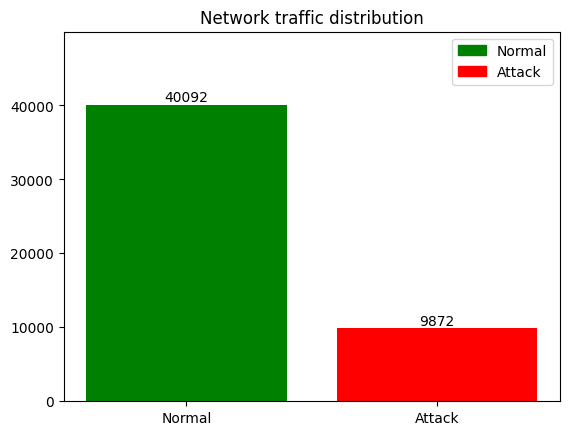

In [23]:
fig, ax = plt.subplots()
bar_container = ax.bar(xaxis_labels, traffic_counts,color =['green','red'])
ax.set(title='Network traffic distribution', ylim=(0, ymax))
ax.bar_label(bar_container, fmt=lambda x: f'{x:.0f}')
ax.legend(handles=handles, labels=legend_labels)

plt.show()

## DOWNSAMPLING

In [24]:
df.loc[:, "is_attack"].value_counts()
rus = RandomUnderSampler(random_state=10, sampling_strategy=0.85) # equals traffic unless ratio is specified
df.drop(["is_attack"], axis=1, inplace=True) # temporarily rm the categorical column for underSampling
all_data_res, trf_type_res = rus.fit_resample(df, is_attack)
#all_datav2 = pd.concat([all_data_res, trf_type_res], join="inner")  # another way to join dataframe w/ series
all_datav2 = all_data_res.join(trf_type_res, how="inner")
all_datav2.shape # check if resulting DaraFrame valid

(21486, 72)

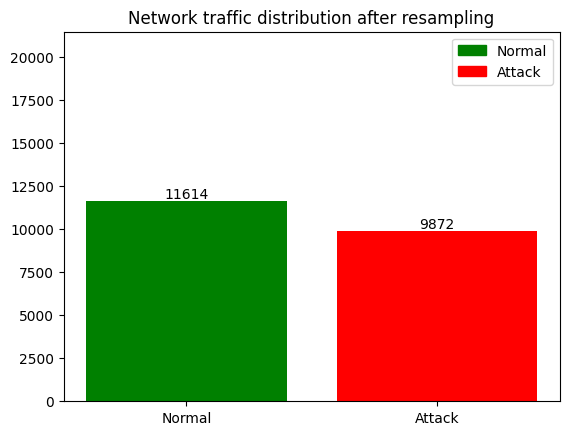

In [25]:
class_counts = all_datav2['is_attack'].value_counts()
xaxis_labels =["Normal","Attack"]
colors = {'Normal':'green','Attack':'red' }
legend_labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in legend_labels]
ymax = all_datav2.shape [0]
count_dict = class_counts.to_dict()
traffic_counts = count_dict.values()

fig, ax = plt.subplots()
bar_container = ax.bar(xaxis_labels, traffic_counts,color =['green','red'])
ax.set(title='Network traffic distribution after resampling', ylim=(0, ymax))
ax.bar_label(bar_container, fmt=lambda x: f'{x:.0f}')
ax.legend(handles=handles, labels=legend_labels)

plt.show()

In [26]:
all_datav2.dropna()
#all_datav2.info()

Destination Port  Flow Duration  Total Fwd Packets  \
11564                80          82137                  3   
38615                80       60109683                  5   
6991                 53       97240359                  3   
44163               443          90639                  6   
47255                53          62141                  2   
...                 ...            ...                ...   
49972              2046             48                  1   
49975              1047             39                  1   
49976                80         589431                  3   
49983                80          16012                  2   
49995                80          59317                  3   

       Total Backward Packets  Total Length of Fwd Packets  \
11564                       4                          443   
38615                       3                          195   
6991                        3                          167   
44163                       8                         1106   
47255                       2                           76   
...                       ...                          ...   
49972                       1                            0   
49975                       1                            2   
49976                       4                           26   
49983                       2                           12   
49995                       6                          300   

       Total Length of Bwd Packets  Fwd Packet Length Max  \
11564                          872                    437   
38615                         1703                    195   
6991                           433                     64   
44163                          538                    821   
47255                          288                     38   
...                            ...                    ...   
49972                            6                      0   
49975                            6                      2   
49976                        11607                     20   
49983                            0                      6   
49995                        11595                    300   

       Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  \
11564                      0              147.666667             250.587975   
38615                      0               39.000000              87.206651   
6991                      43               55.666667              11.150486   
44163                      0              184.333333             322.457232   
47255                     38               38.000000               0.000000   
...                      ...                     ...                    ...   
49972                      0                0.000000               0.000000   
49975                      2                2.000000               0.000000   
49976                      0                8.666667              10.263203   
49983                      6                6.000000               0.000000   
49995                      0              100.000000             173.205081   

       ...  Active Mean   Active Std  Active Max  Active Min   Idle Mean  \
11564  ...          0.0     0.000000           0           0         0.0   
38615  ...          0.0     0.000000           0           0         0.0   
6991   ...      65165.5  3261.883582       67472       62859  48500000.0   
44163  ...          0.0     0.000000           0           0         0.0   
47255  ...          0.0     0.000000           0           0         0.0   
...    ...          ...          ...         ...         ...         ...   
49972  ...          0.0     0.000000           0           0         0.0   
49975  ...          0.0     0.000000           0           0         0.0   
49976  ...          0.0     0.000000           0           0         0.0   
49983  ...          0.0     0.000000           0           0         0.0   
49995  ... 

## CALCULATING FEATURES' IMPORTANCE

In [27]:
## feature selection phase - prepare data for RFC
#lbls = all_datav2.loc[:, "Label"]
data_w_o_cat_attrs = all_datav2.iloc[:, :-2]
#lbls
data_w_o_cat_attrs

Destination Port  Flow Duration  Total Fwd Packets  \
11564                80          82137                  3   
38615                80       60109683                  5   
6991                 53       97240359                  3   
44163               443          90639                  6   
47255                53          62141                  2   
...                 ...            ...                ...   
49972              2046             48                  1   
49975              1047             39                  1   
49976                80         589431                  3   
49983                80          16012                  2   
49995                80          59317                  3   

       Total Backward Packets  Total Length of Fwd Packets  \
11564                       4                          443   
38615                       3                          195   
6991                        3                          167   
44163                       8                         1106   
47255                       2                           76   
...                       ...                          ...   
49972                       1                            0   
49975                       1                            2   
49976                       4                           26   
49983                       2                           12   
49995                       6                          300   

       Total Length of Bwd Packets  Fwd Packet Length Max  \
11564                          872                    437   
38615                         1703                    195   
6991                           433                     64   
44163                          538                    821   
47255                          288                     38   
...                            ...                    ...   
49972                            6                      0   
49975                            6                      2   
49976                        11607                     20   
49983                            0                      6   
49995                        11595                    300   

       Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  \
11564                      0              147.666667             250.587975   
38615                      0               39.000000              87.206651   
6991                      43               55.666667              11.150486   
44163                      0              184.333333             322.457232   
47255                     38               38.000000               0.000000   
...                      ...                     ...                    ...   
49972                      0                0.000000               0.000000   
49975                      2                2.000000               0.000000   
49976                      0                8.666667              10.263203   
49983                      6                6.000000               0.000000   
49995                      0              100.000000             173.205081   

       ...  act_data_pkt_fwd  min_seg_size_forward  Active Mean   Active Std  \
11564  ...                 2                    20          0.0     0.000000   
38615  ...                 1                    20          0.0     0.000000   
6991   ...                 2                    32      65165.5  3261.883582   
44163  ...                 3                    32          0.0     0.000000   
47255  ...                 1                    20          0.0     0.000000   
...    ...               ...                   ...          ...          ...   
49972  ...                 0                    40          0.0     0.000000   
49975  ...                 0                    24          0.0     0.000000   
49976  ...                 2                    20          0.0     0.000000   
49983  ...                 1                   

In [28]:
lbls = all_datav2.loc[:, "is_attack"] #"Label"
lbls.head(3)

11564    0
38615    0
6991     0
Name: is_attack, dtype: int64

In [29]:
use_rf = False
importances = None
if use_rf:
  importances = get_feature_importances_rf(data_w_o_cat_attrs, lbls)

else:
  importances = get_feature_importances_xgb(data_w_o_cat_attrs, lbls)

importances

level of importance
features                                   
Average Packet Size                 0.21627
Bwd Packet Length Min               0.15907
Bwd Header Length                   0.14640
Bwd Packet Length Std               0.12488
Max Packet Length                   0.04014
...                                     ...
Fwd IAT Max                         0.00000
Packet Length Variance              0.00000
Bwd IAT Total                       0.00000
Min Packet Length                   0.00000
Idle Min                            0.00000

[70 rows x 1 columns]

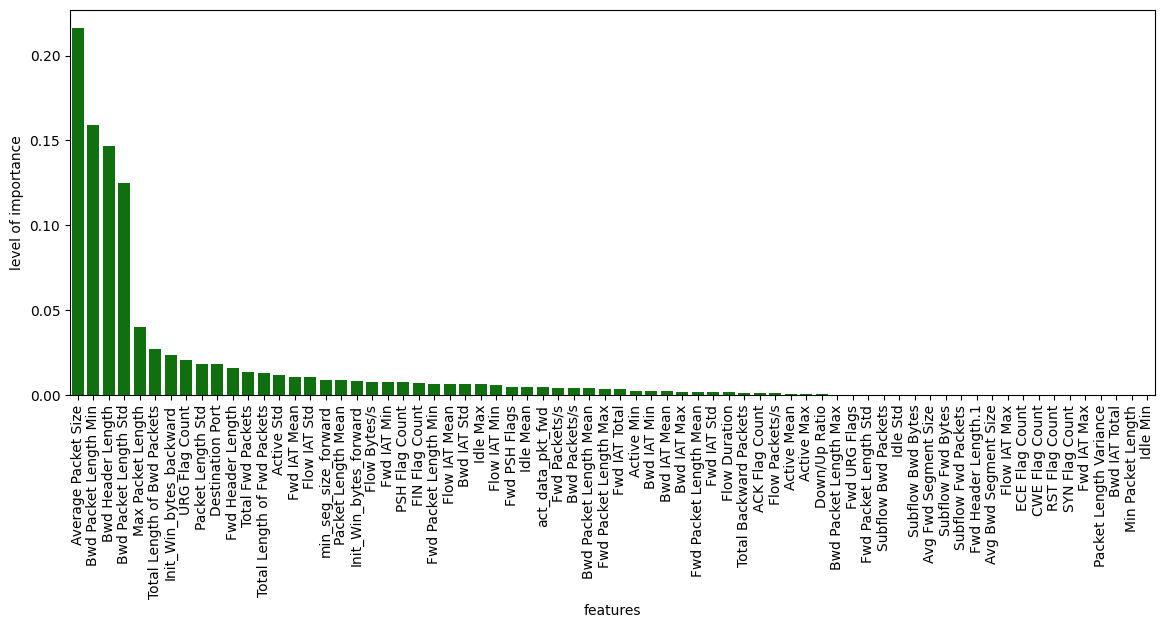

In [30]:
# plot importances
sns.barplot(x=importances.index, y="level of importance", data=importances, color="green")
plt.xticks(rotation="vertical")
plt.gcf().set_size_inches(14,5)
#plt.savefig("importances.png", dpi=200, format='png', bbox_inches = "tight", pad_inches=0.2)
plt.show()

In [31]:
threshold = 0.001 # importance threshold
bl_thresh = importances.loc[importances["level of importance"] < threshold]
print("there are {} features to delete, as they are below chosen threshold".format(bl_thresh.shape[0]))
print("these features are the following:")
feats_to_del = [feat for feat in bl_thresh.index]
print("\n".join(feats_to_del))

there are 25 features to delete, as they are below chosen threshold
these features are the following:
Flow Packets/s
Active Mean
Active Max
Down/Up Ratio
Bwd Packet Length Max
Fwd URG Flags
Fwd Packet Length Std
Subflow Bwd Packets
Idle Std
Subflow Bwd Bytes
Avg Fwd Segment Size
Subflow Fwd Bytes
Subflow Fwd Packets
Fwd Header Length.1
Avg Bwd Segment Size
Flow IAT Max
ECE Flag Count
CWE Flag Count
RST Flag Count
SYN Flag Count
Fwd IAT Max
Packet Length Variance
Bwd IAT Total
Min Packet Length
Idle Min


In [32]:
## removing these not important features
all_datav2.drop(columns=feats_to_del, inplace=True)

In [33]:
all_datav2.head(3)

Destination Port  Flow Duration  Total Fwd Packets  \
11564                80          82137                  3   
38615                80       60109683                  5   
6991                 53       97240359                  3   

       Total Backward Packets  Total Length of Fwd Packets  \
11564                       4                          443   
38615                       3                          195   
6991                        3                          167   

       Total Length of Bwd Packets  Fwd Packet Length Max  \
11564                          872                    437   
38615                         1703                    195   
6991                           433                     64   

       Fwd Packet Length Min  Fwd Packet Length Mean  Bwd Packet Length Min  \
11564                      0              147.666667                      0   
38615                      0               39.000000                      0   
6991                      43               55.666667                    118   

       ...  Init_Win_bytes_forward  Init_Win_bytes_backward  act_data_pkt_fwd  \
11564  ...                    8192                       31                 2   
38615  ...                    8192                      946                 1   
6991   ...                      -1                       -1                 2   

       min_seg_size_forward   Active Std  Active Min   Idle Mean  Idle Max  \
11564                    20     0.000000           0         0.0         0   
38615                    20     0.000000           0         0.0         0   
6991                     32  3261.883582       62859  48500000.0  77800000   

        Label  is_attack  
11564  BENIGN          0  
38615  BENIGN          0  
6991   BENIGN          0  

[3 rows x 47 columns]

DETECTING HIGHLY CORRELATED FEATURES

In [34]:
all_datav2 = all_datav2.drop(columns =["Label"]).copy()
#all_datav2
all_datav2.head(3)

Destination Port  Flow Duration  Total Fwd Packets  \
11564                80          82137                  3   
38615                80       60109683                  5   
6991                 53       97240359                  3   

       Total Backward Packets  Total Length of Fwd Packets  \
11564                       4                          443   
38615                       3                          195   
6991                        3                          167   

       Total Length of Bwd Packets  Fwd Packet Length Max  \
11564                          872                    437   
38615                         1703                    195   
6991                           433                     64   

       Fwd Packet Length Min  Fwd Packet Length Mean  Bwd Packet Length Min  \
11564                      0              147.666667                      0   
38615                      0               39.000000                      0   
6991                      43               55.666667                    118   

       ...  Average Packet Size  Init_Win_bytes_forward  \
11564  ...           187.857143                    8192   
38615  ...           237.250000                    8192   
6991   ...           110.666667                      -1   

       Init_Win_bytes_backward  act_data_pkt_fwd  min_seg_size_forward  \
11564                       31                 2                    20   
38615                      946                 1                    20   
6991                        -1                 2                    32   

        Active Std  Active Min   Idle Mean  Idle Max  is_attack  
11564     0.000000           0         0.0         0          0  
38615     0.000000           0         0.0         0          0  
6991   3261.883582       62859  48500000.0  77800000          0  

[3 rows x 46 columns]

In [35]:
all_data_corr_mtrx = all_datav2.corr()

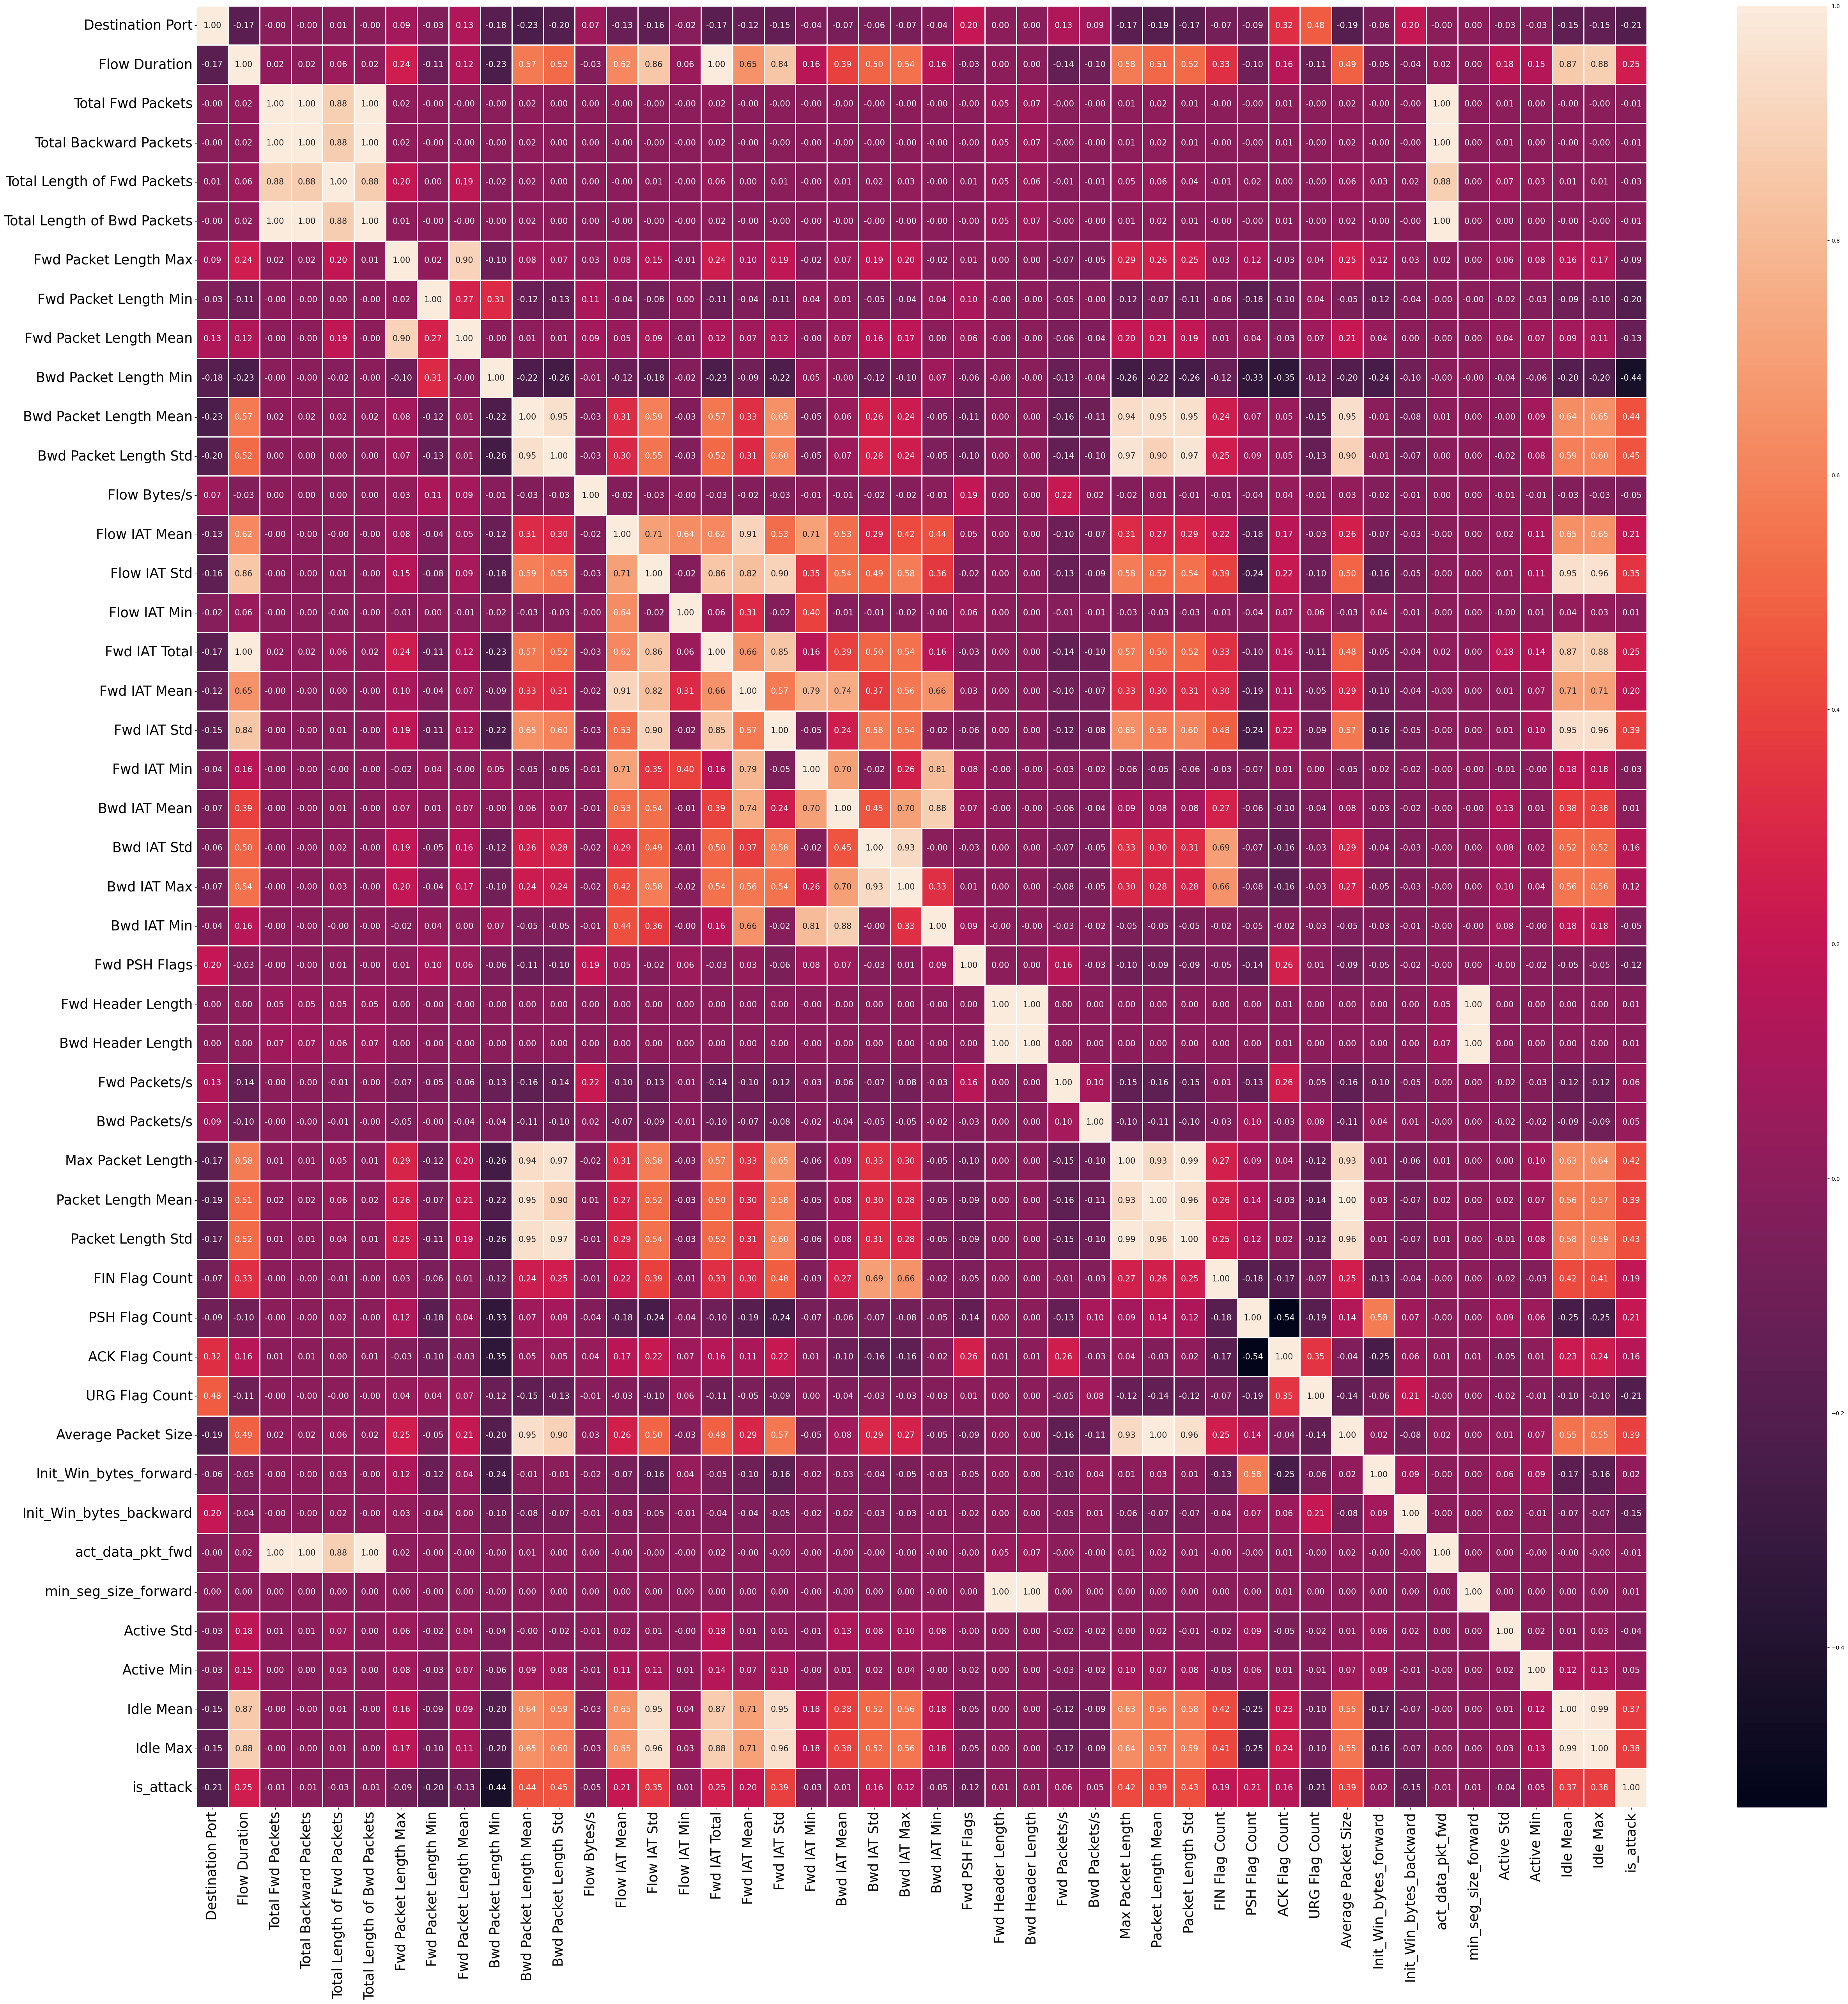

In [36]:
## plotting a correlation heatmap

plt.gcf().set_size_inches(60, 60)
hm = sns.heatmap(all_data_corr_mtrx, annot=True, linewidths=.8, annot_kws={"fontsize": 15}, fmt=".2f")
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 25)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 25)
#plt.savefig("corr_heatmap.png", dpi=200, format='png', bbox_inches = "tight", pad_inches=0.4)
plt.show()

In [37]:
srt_corr(all_data_corr_mtrx)

Destination Port        Destination Port          1.000000e+00
Bwd IAT Min             Bwd IAT Min               1.000000e+00
Bwd IAT Std             Bwd IAT Std               1.000000e+00
Bwd IAT Mean            Bwd IAT Mean              1.000000e+00
Fwd IAT Min             Fwd IAT Min               1.000000e+00
                                                      ...     
act_data_pkt_fwd        min_seg_size_forward      4.001474e-05
                        Active Min                1.450496e-05
Active Min              act_data_pkt_fwd          1.450496e-05
Fwd Packet Length Mean  min_seg_size_forward      8.717688e-07
min_seg_size_forward    Fwd Packet Length Mean    8.717688e-07
Length: 2116, dtype: float64

In [38]:
thres_corr = 0.95
epoch=0
highly_corr = {"dummy": "dummy"}
feats_deled = []

all_data_corr_mtrx2 = all_data_corr_mtrx.copy()  # for easy
def add_to_dct(l, ft, ft2):
    try:
        l[ft].append(ft2)
    except KeyError:
        l[ft] = [ft2]

get_imp = lambda feat: importances.loc[feat][0]
srt_key = lambda elem: get_imp(elem[0])  # gets imp of first elem

while highly_corr:
    count = 0
    highly_corr.clear()
    for feats, val in srt_corr(all_data_corr_mtrx2).items():
        if val > thres_corr and feats[0] != feats[1]:
            count += 1
            add_to_dct(highly_corr, feats[0], feats[1])
    if not highly_corr: break  # no more highly corr pairs
    highly_corr_srt = OrderedDict(sorted(highly_corr.items(), key=srt_key))  # sorted based on imp

    to_del = what_to_del(highly_corr_srt)
    feats_deled += to_del
    epoch +=1 # first epoch will be 1 not 0!
    print("there are {} higly correlated pairs in {} iteration".format(count, epoch))
    all_data_corr_mtrx2.drop(to_del, axis=1, inplace=True)
    all_data_corr_mtrx2.drop(to_del, axis=0, inplace=True)  # need to remove the feat from both cols and index

print("deleting: {} feature".format(len(feats_deled)))
print("finally deleted:\n"+ "\n".join(feats_deled))

there are 46 higly correlated pairs in 1 iteration
deleting: 13 feature
finally deleted:
Total Backward Packets
Flow Duration
Fwd IAT Std
Bwd Packet Length Mean
act_data_pkt_fwd
Idle Mean
Idle Max
Packet Length Mean
min_seg_size_forward
Total Fwd Packets
Fwd Header Length
Packet Length Std
Max Packet Length


<ipython-input-38-c6ee6f6ea588>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  get_imp = lambda feat: importances.loc[feat][0]


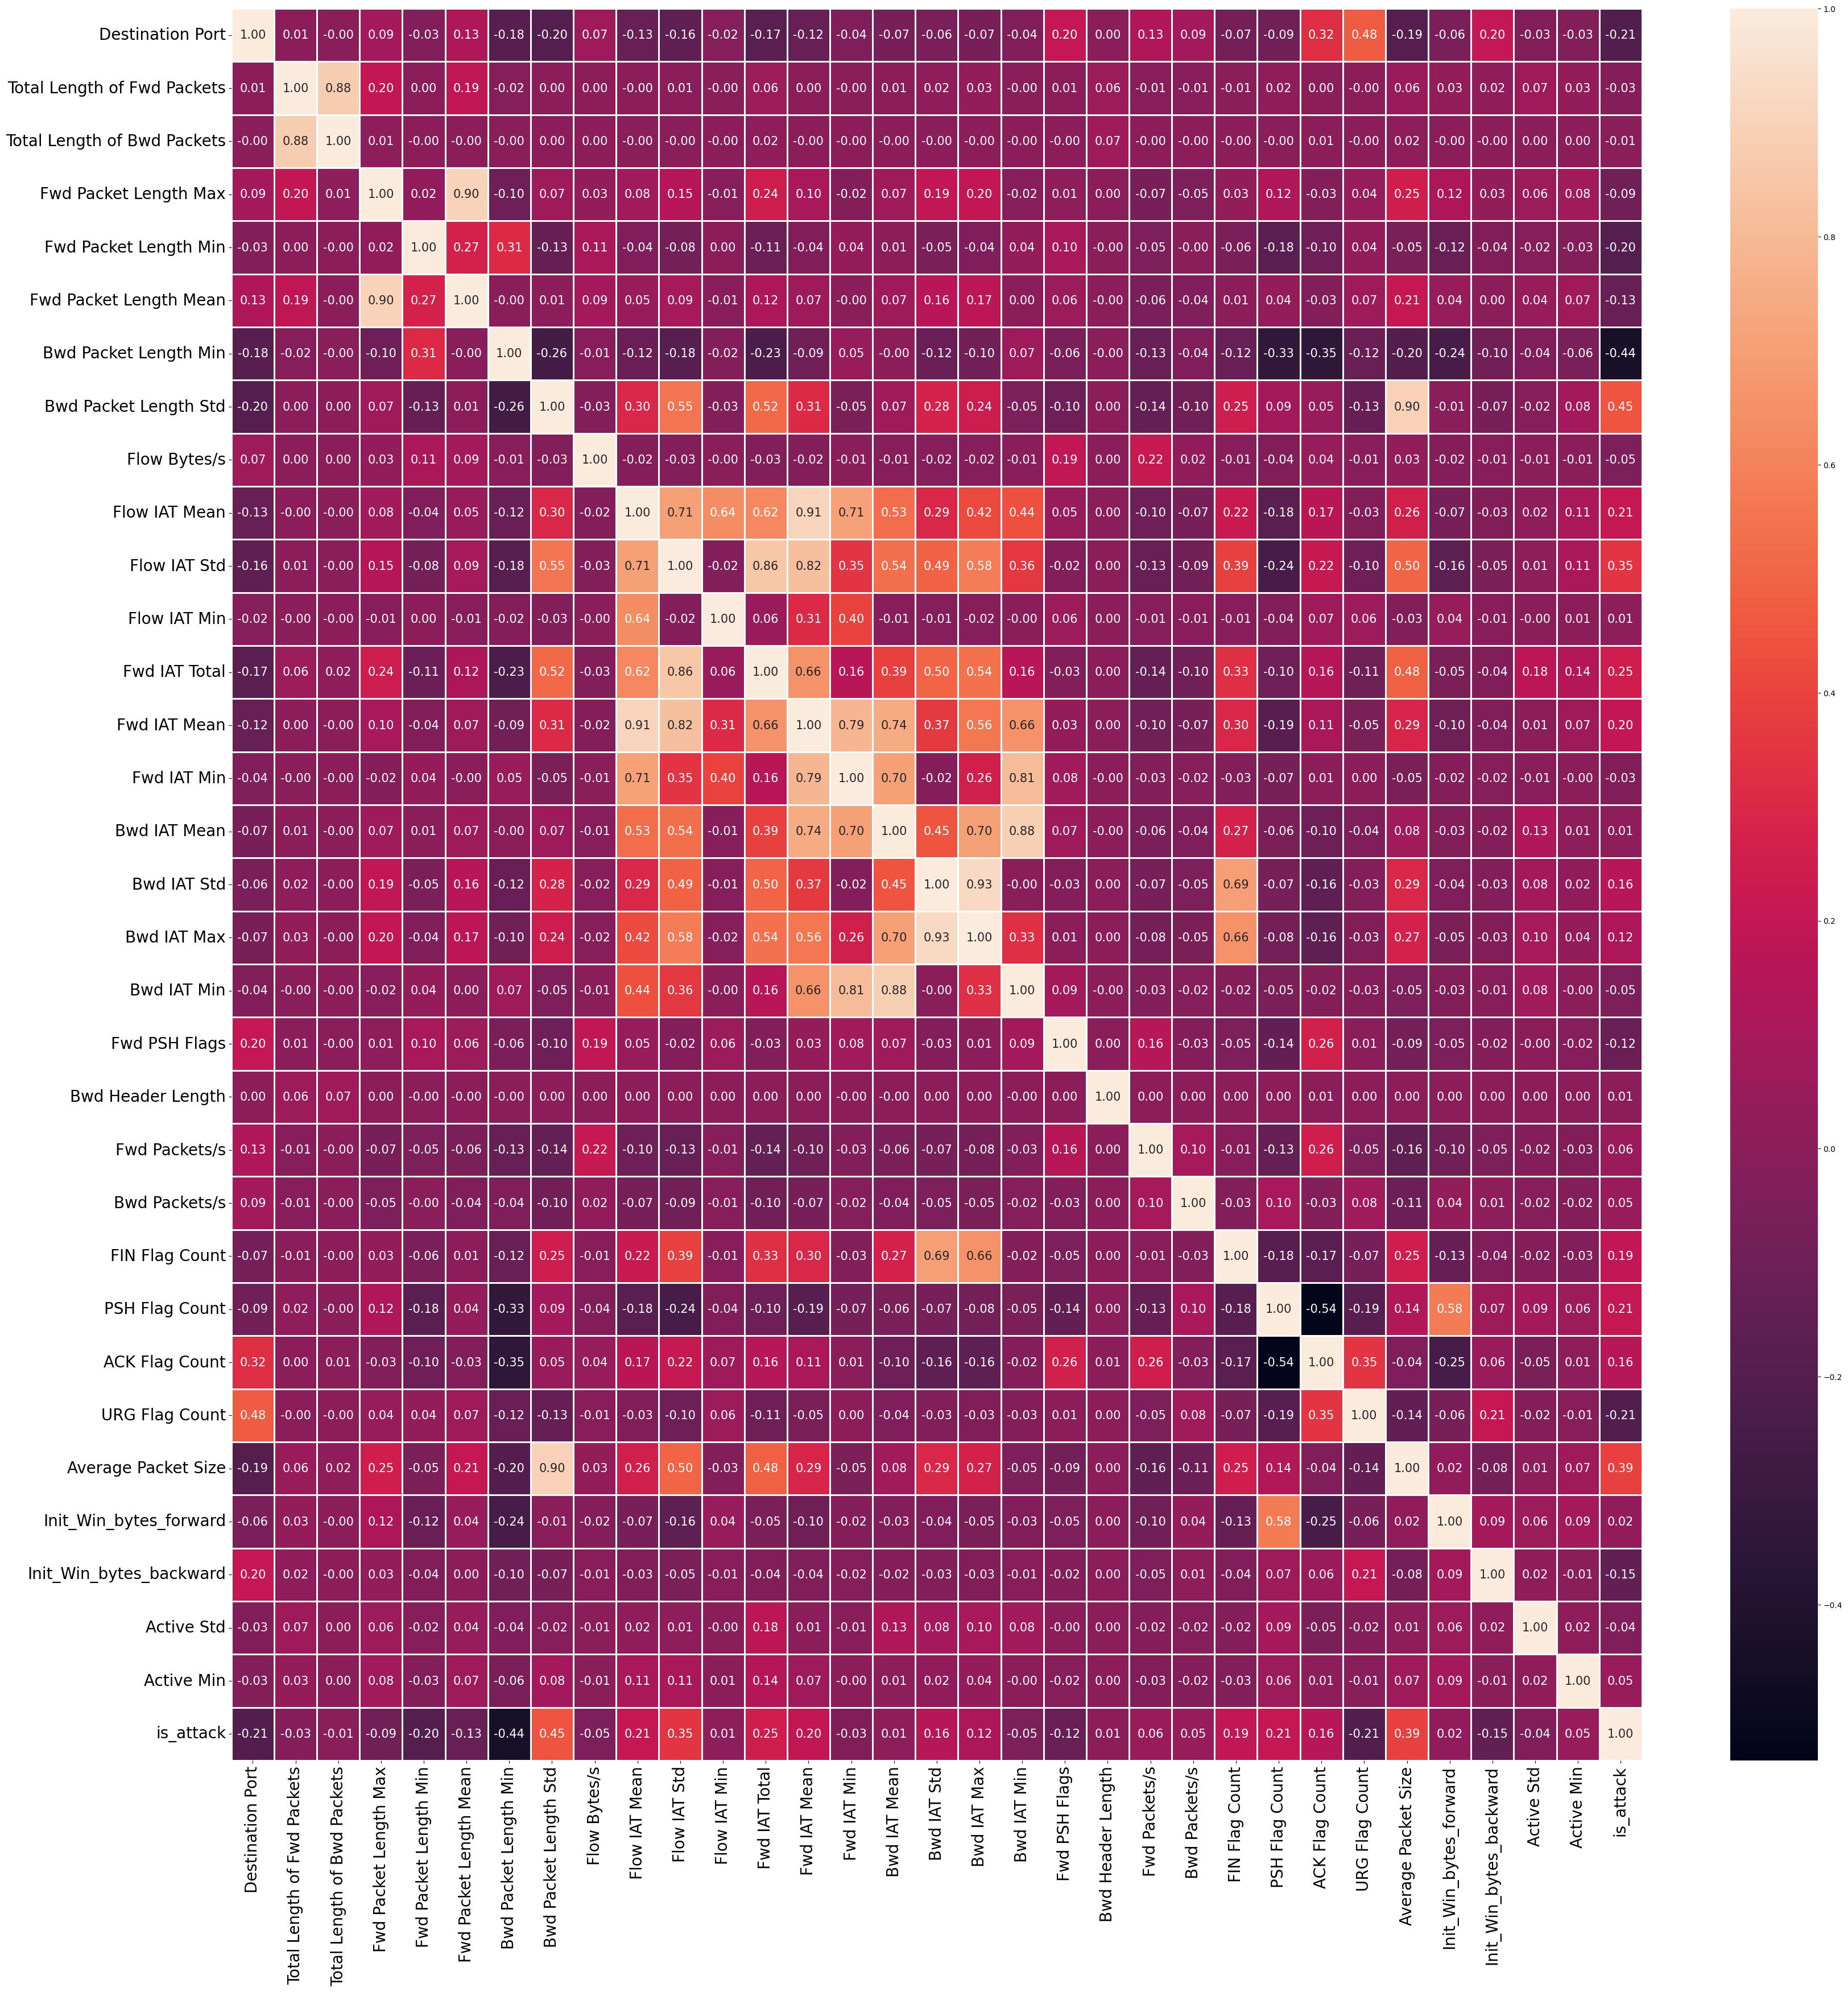

In [39]:
plt.gcf().set_size_inches(40, 40)
hm2 = sns.heatmap(all_data_corr_mtrx2, annot=True, linewidths=.8, annot_kws={"fontsize": 15}, fmt=".2f")
hm2.set_yticklabels(hm2.get_ymajorticklabels(), fontsize = 20)
hm2.set_xticklabels(hm2.get_xmajorticklabels(), fontsize = 20)
#plt.savefig("corr_heatmap2.png", dpi=200, format='png', bbox_inches = "tight", pad_inches=0.4)
plt.show()

In [40]:
DF = all_datav2.copy() ## just for ease of cells executing
DF.drop(feats_deled, axis=1, inplace=True)
all_datav3_cp = DF.copy()
DF.head(3) # just check

Destination Port  Total Length of Fwd Packets  \
11564                80                          443   
38615                80                          195   
6991                 53                          167   

       Total Length of Bwd Packets  Fwd Packet Length Max  \
11564                          872                    437   
38615                         1703                    195   
6991                           433                     64   

       Fwd Packet Length Min  Fwd Packet Length Mean  Bwd Packet Length Min  \
11564                      0              147.666667                      0   
38615                      0               39.000000                      0   
6991                      43               55.666667                    118   

       Bwd Packet Length Std  Flow Bytes/s  Flow IAT Mean  ...  \
11564             428.009346  16009.837223   1.368950e+04  ...   
38615             983.227508     31.575612   8.587098e+06  ...   
6991               35.725808      6.170278   1.940000e+07  ...   

       FIN Flag Count  PSH Flag Count  ACK Flag Count  URG Flag Count  \
11564               0               1               0               0   
38615               0               1               0               0   
6991                0               0               0               0   

       Average Packet Size  Init_Win_bytes_forward  Init_Win_bytes_backward  \
11564           187.857143                    8192                       31   
38615           237.250000                    8192                      946   
6991            110.666667                      -1                       -1   

        Active Std  Active Min  is_attack  
11564     0.000000           0          0  
38615     0.000000           0          0  
6991   3261.883582       62859          0  

[3 rows x 33 columns]

In [41]:
DF.drop(columns=['Destination Port'],axis=1,  inplace=True)
DF.head(3) # just check

Total Length of Fwd Packets  Total Length of Bwd Packets  \
11564                          443                          872   
38615                          195                         1703   
6991                           167                          433   

       Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
11564                    437                      0              147.666667   
38615                    195                      0               39.000000   
6991                      64                     43               55.666667   

       Bwd Packet Length Min  Bwd Packet Length Std  Flow Bytes/s  \
11564                      0             428.009346  16009.837223   
38615                      0             983.227508     31.575612   
6991                     118              35.725808      6.170278   

       Flow IAT Mean  Flow IAT Std  ...  FIN Flag Count  PSH Flag Count  \
11564   1.368950e+04  1.539307e+04  ...               0               1   
38615   8.587098e+06  2.270000e+07  ...               0               1   
6991    1.940000e+07  3.370000e+07  ...               0               0   

       ACK Flag Count  URG Flag Count  Average Packet Size  \
11564               0               0           187.857143   
38615               0               0           237.250000   
6991                0               0           110.666667   

       Init_Win_bytes_forward  Init_Win_bytes_backward   Active Std  \
11564                    8192                       31     0.000000   
38615                    8192                      946     0.000000   
6991                       -1                       -1  3261.883582   

       Active Min  is_attack  
11564           0          0  
38615           0          0  
6991        62859          0  

[3 rows x 32 columns]

In [42]:
DF.describe().T

count          mean           std  \
Total Length of Fwd Packets  21486.0  5.085767e+02  9.612191e+03   
Total Length of Bwd Packets  21486.0  3.504339e+04  4.170425e+06   
Fwd Packet Length Max        21486.0  1.805235e+02  6.339439e+02   
Fwd Packet Length Min        21486.0  1.324835e+01  5.252037e+01   
Fwd Packet Length Mean       21486.0  4.804123e+01  1.651881e+02   
Bwd Packet Length Min        21486.0  2.810081e+01  5.556936e+01   
Bwd Packet Length Std        21486.0  6.095991e+02  1.171790e+03   
Flow Bytes/s                 21486.0  1.062403e+06  1.725866e+07   
Flow IAT Mean                21486.0  1.805016e+06  4.828313e+06   
Flow IAT Std                 21486.0  4.717707e+06  9.955294e+06   
Flow IAT Min                 21486.0  1.746788e+05  3.146504e+06   
Fwd IAT Total                21486.0  1.925441e+07  3.727786e+07   
Fwd IAT Mean                 21486.0  3.540314e+06  9.612105e+06   
Fwd IAT Min                  21486.0  8.229948e+05  7.835078e+06   
Bwd IAT Mean                 21486.0  1.788342e+06  8.225031e+06   
Bwd IAT Std                  21486.0  2.167980e+06  8.296176e+06   
Bwd IAT Max                  21486.0  5.973232e+06  2.089154e+07   
Bwd IAT Min                  21486.0  7.179601e+05  7.208676e+06   
Fwd PSH Flags                21486.0  3.741972e-02  1.897924e-01   
Bwd Header Length            21486.0 -3.492985e+03  5.735993e+05   
Fwd Packets/s                21486.0  7.253921e+04  2.725961e+05   
Bwd Packets/s                21486.0  7.819482e+03  4.198729e+04   
FIN Flag Count               21486.0  6.022526e-02  2.379093e-01   
PSH Flag Count               21486.0  3.439449e-01  4.750340e-01   
ACK Flag Count               21486.0  3.568370e-01  4.790773e-01   
URG Flag Count               21486.0  6.343666e-02  2.437524e-01   
Average Packet Size          21486.0  2.802354e+02  4.333041e+02   
Init_Win_bytes_forward       21486.0  7.006937e+03  1.341691e+04   
Init_Win_bytes_backward      21486.0  1.437765e+03  7.113866e+03   
Active Std                   21486.0  3.475982e+04  3.923999e+05   
Active Min                   21486.0  7.054670e+04  5.482276e+05   
is_attack                    21486.0  4.594620e-01  4.983656e-01   

                                      min         25%           50%  \
Total Length of Fwd Packets  0.000000e+00    2.000000     51.000000   
Total Length of Bwd Packets  0.000000e+00    0.000000    112.000000   
Fwd Packet Length Max        0.000000e+00    2.000000     31.000000   
Fwd Packet Length Min        0.000000e+00    0.000000      0.000000   
Fwd Packet Length Mean       0.000000e+00    2.000000     26.500000   
Bwd Packet Length Min        0.000000e+00    0.000000      0.000000   
Bwd Packet Length Std        0.000000e+00    0.000000      0.000000   
Flow Bytes/s                 0.000000e+00  118.877594   3431.226560   
Flow IAT Mean                5.000000e-01   60.000000  13041.083333   
Flow IAT Std                 0.000000e+00    0.000000   5054.225399   
Flow IAT Min                -1.300000e+01    3.000000      4.000000   
Fwd IAT Total                0.000000e+00    0.000000     70.000000   
Fwd IAT Mean                 0.000000e+00    0.000000     62.000000   
Fwd IAT Min                 -1.000000e+00    0.000000      3.000000   
Bwd IAT Mean                 0.000000e+00    0.000000      3.000000   
Bwd IAT Std                  0.000000e+00    0.000000      0.000000   
Bwd IAT Max                  0.000000e+00    0.000000      3.000000   
Bwd IAT Min                  0.000000e+00    0.000000      1.000000   
Fwd PSH Flags                0.000000e+00    0.000000      0.000000   
Bwd Header Length           -8.388522e+07   20.000000     40.000000   
Fwd Packets/s                1.667194e-02    0.728764     50.809482   
Bwd Packets/s                0.000000e+00    0.060944      9.396581   
FIN Flag Count               0.000000e+00    0.000000      0.000000   
PSH Flag Count               0.000000e+00    0.000000      0.000000   
ACK Flag Co

## Estandarization of data

### Splitting data

In [43]:
train_set, val_set, test_set = train_val_test_split(DF)
x_train= train_set.drop(columns=['is_attack'] ).copy()
y_train= train_set['is_attack'].copy()

x_val= val_set.drop(columns=['is_attack'] ).copy()
y_val= val_set['is_attack'].copy()

x_test= test_set.drop(columns=['is_attack'] ).copy()
y_test= test_set['is_attack'].copy()


### Transforming data using a robust scaler

In [44]:
robust_scaler = RobustScaler()
x_train_tr = robust_scaler.fit_transform(x_train)
x_val_tr = robust_scaler.transform(x_val)
x_test_tr = robust_scaler.transform(x_test)

# TRAINING MODELS

## LOGISTIC REGRESSION

In [45]:
clf = LogisticRegression(random_state=0, max_iter=5000,solver="newton-cg",)
clf.fit(x_train_tr, y_train)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


LogisticRegression(max_iter=5000, random_state=0, solver='newton-cg')

### validating model

In [46]:
y_pred = clf.predict(x_val_tr)

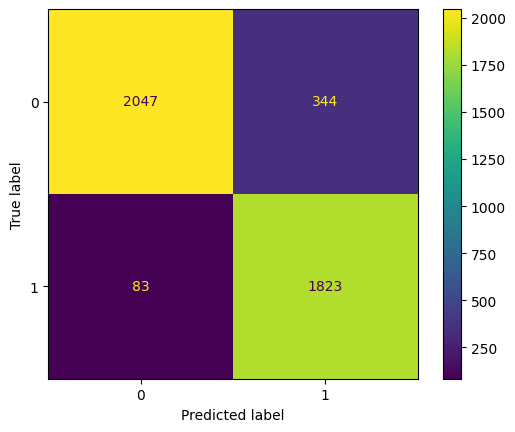

In [47]:
ConfusionMatrixDisplay.from_estimator(clf, x_val_tr, y_val, values_format='d')

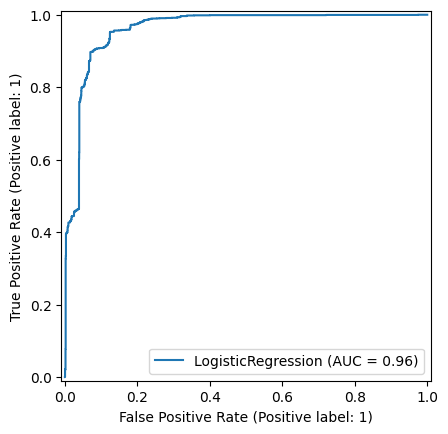

In [48]:
RocCurveDisplay.from_estimator(clf, x_val_tr, y_val)

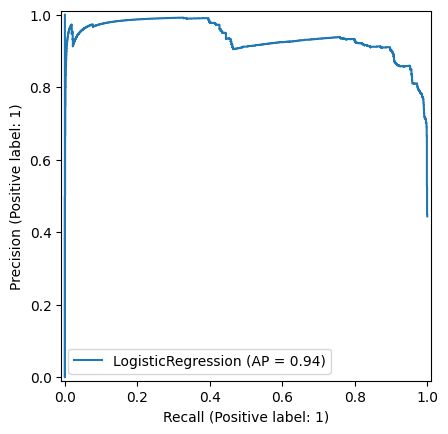

In [49]:
PrecisionRecallDisplay.from_estimator(clf, x_val_tr, y_val)

In [50]:
f1_score(y_val, y_pred)

0.8951632703167198

### Testing model

In [51]:
y_pred = clf.predict(x_test_tr)

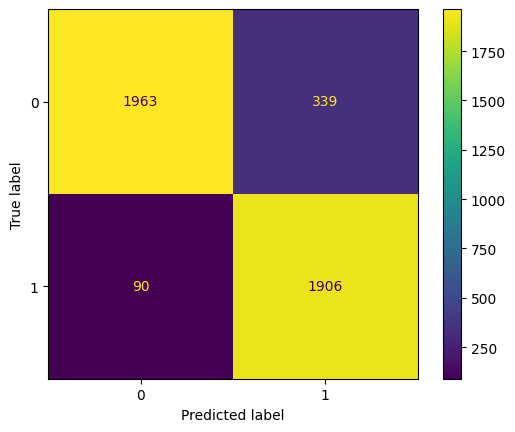

In [52]:
ConfusionMatrixDisplay.from_estimator(clf, x_test_tr, y_test, values_format='d')

In [53]:
F1_LR = f1_score(y_test, y_pred)
F1_LR

0.8988446121197831

## SUPPORT VECTOR MACHINE

In [54]:
param_grid = {
    'C': [1, 10, 50],
    'gamma': ['scale', 'auto', 0.01, 0.1],
}
grid_search = GridSearchCV(SVC(kernel="rbf"), param_grid, scoring='f1', cv=3)
grid_search.fit(x_train_tr, y_train)

print("Best Parameters:", grid_search.best_params_)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'C': 50, 'gamma': 0.01}


In [55]:
svm_clf = SVC(kernel="rbf", C=50, gamma=0.01) #svm_clf = SVC(kernel="rbf", C=50)
svm_clf.fit(x_train_tr, y_train)

SVC(C=50, gamma=0.01)

### validating

In [56]:
y_pred = svm_clf.predict(x_val_tr)

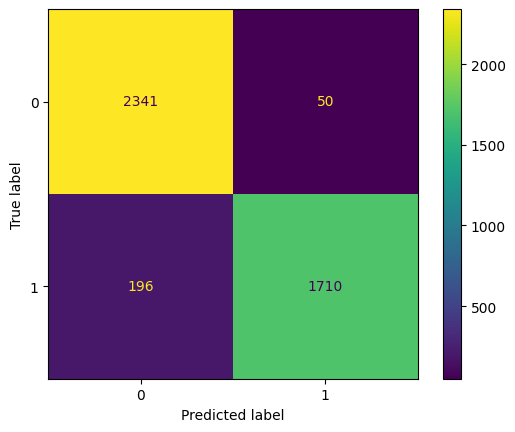

In [57]:
ConfusionMatrixDisplay.from_estimator(svm_clf, x_val_tr, y_val, values_format='d')

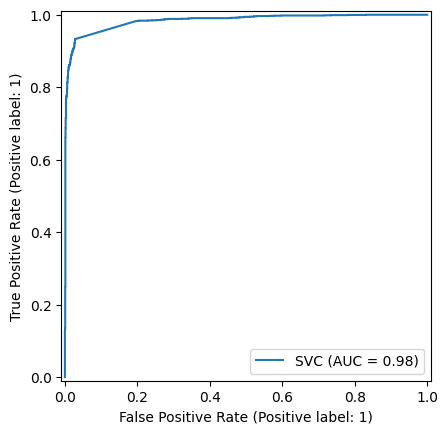

In [58]:
RocCurveDisplay.from_estimator(svm_clf, x_val_tr, y_val)

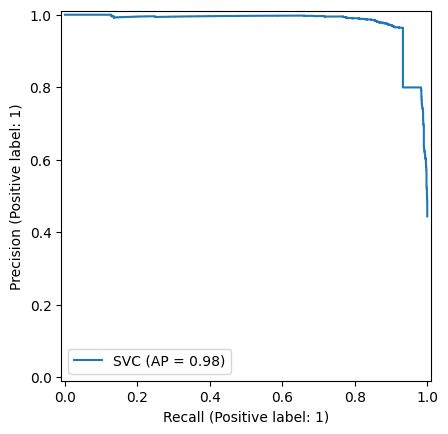

In [59]:
PrecisionRecallDisplay.from_estimator(svm_clf, x_val_tr, y_val)

In [60]:
f1_score(y_val, y_pred)

0.9328968903436988

### testing

In [61]:
y_pred = svm_clf.predict(x_test_tr)

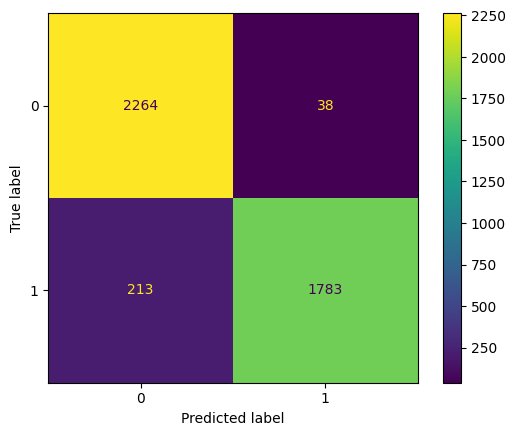

In [62]:
ConfusionMatrixDisplay.from_estimator(svm_clf, x_test_tr, y_test, values_format='d')

In [63]:
F1_SVM = f1_score(y_test, y_pred)
F1_SVM

0.9342415509562484

## DECISION TREE

In [64]:
dtre_clf = DecisionTreeClassifier()
dtre_clf.fit(x_train_tr, y_train)

DecisionTreeClassifier()

### validating

In [65]:
y_pred = dtre_clf.predict(x_val_tr)

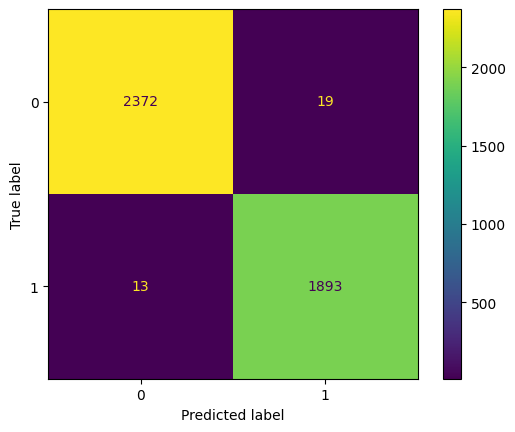

In [66]:
ConfusionMatrixDisplay.from_estimator(dtre_clf, x_val_tr, y_val, values_format='d')

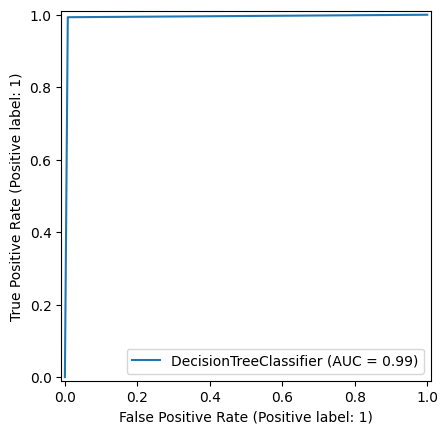

In [67]:
RocCurveDisplay.from_estimator(dtre_clf, x_val_tr, y_val)


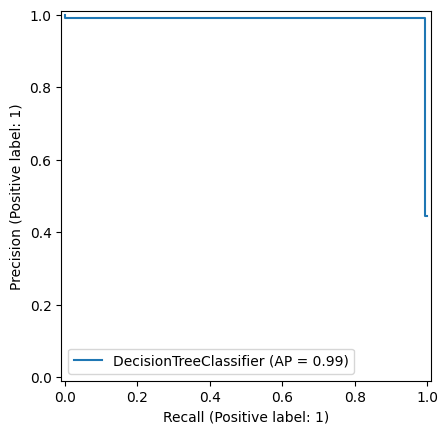

In [68]:
PrecisionRecallDisplay.from_estimator(dtre_clf, x_val_tr, y_val)

In [69]:
f1_score(y_val, y_pred)

0.9916186485070718

### Testing model

In [70]:
y_pred = dtre_clf.predict(x_test_tr)

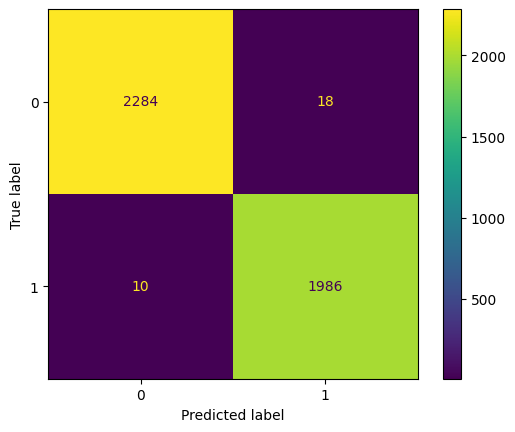

In [71]:
ConfusionMatrixDisplay.from_estimator(dtre_clf, x_test_tr, y_test, values_format='d')

In [72]:
F1_DT = f1_score(y_test, y_pred)
F1_DT

0.993

## RANDOM FOREST

In [73]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
rf_clf.fit(x_train_tr, y_train)

RandomForestClassifier(random_state=0)

### Validating model

In [74]:
y_pred = rf_clf.predict(x_val_tr)

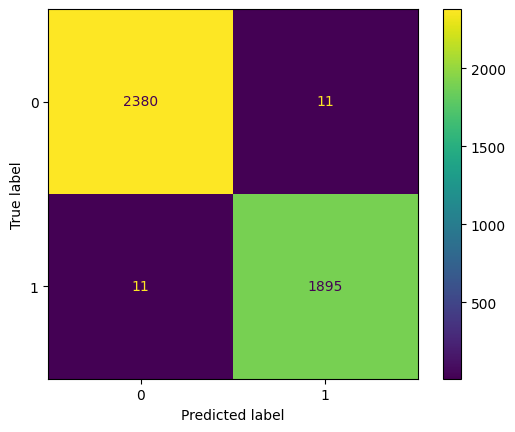

In [75]:
ConfusionMatrixDisplay.from_estimator(rf_clf, x_val_tr, y_val, values_format='d')

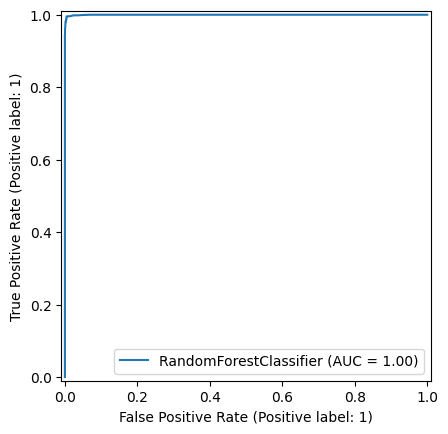

In [76]:
RocCurveDisplay.from_estimator(rf_clf, x_val_tr, y_val)

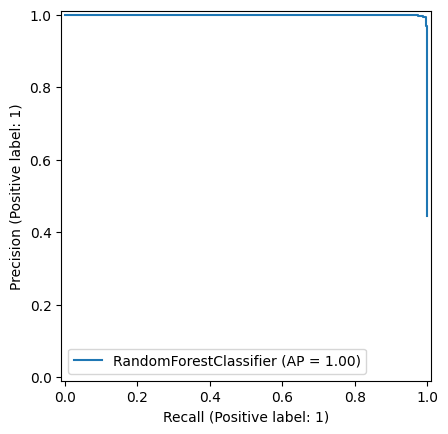

In [77]:

PrecisionRecallDisplay.from_estimator(rf_clf, x_val_tr, y_val)

In [78]:
f1_score(y_val, y_pred)


0.9942287513116475

### Testing

In [79]:
y_pred =rf_clf.predict(x_test_tr)

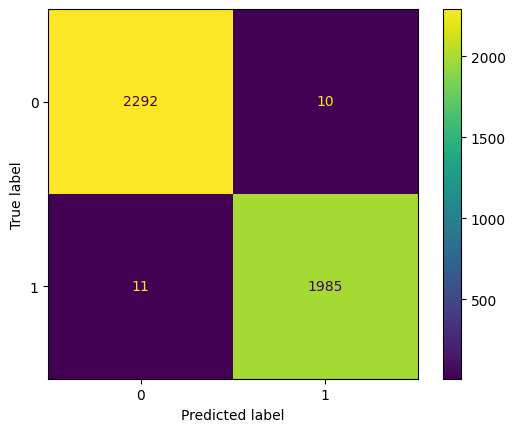

In [80]:
ConfusionMatrixDisplay.from_estimator(rf_clf, x_test_tr, y_test, values_format='d')

In [81]:
RF_LR = f1_score(y_test, y_pred)
RF_LR

0.9947381608619393

## KNN

In [82]:
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(x_train_tr, y_train)

KNeighborsClassifier()

### Validating model

In [83]:
y_pred = knn_clf.predict(x_val_tr)

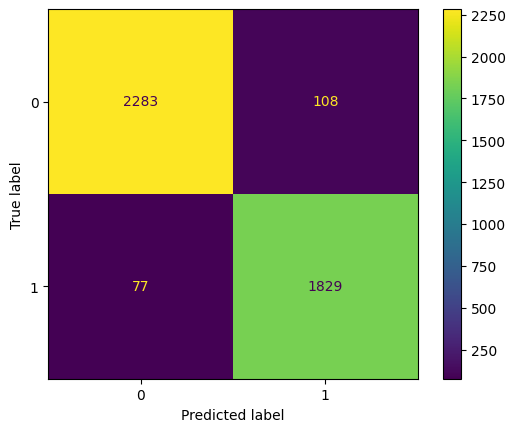

In [84]:
ConfusionMatrixDisplay.from_estimator(knn_clf, x_val_tr, y_val, values_format='d')

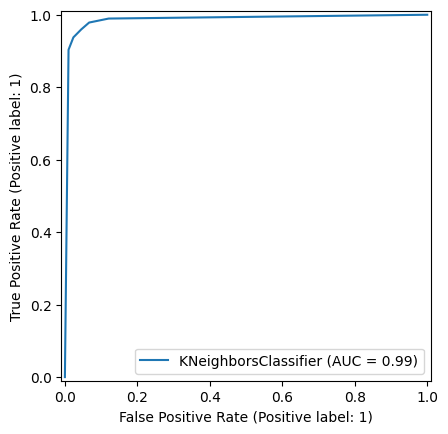

In [85]:
RocCurveDisplay.from_estimator(knn_clf, x_val_tr, y_val)

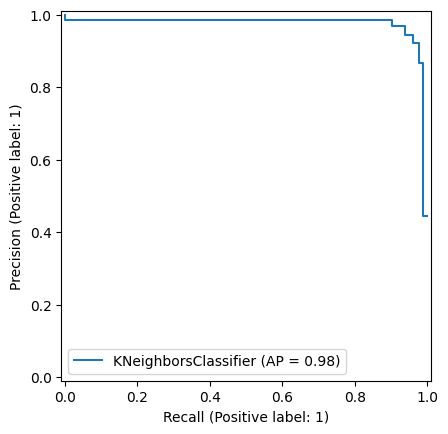

In [86]:
PrecisionRecallDisplay.from_estimator(knn_clf, x_val_tr, y_val)

In [87]:
f1_score(y_val, y_pred)

0.9518605256310174

### testin model

In [88]:
y_pred=knn_clf.predict(x_test_tr)

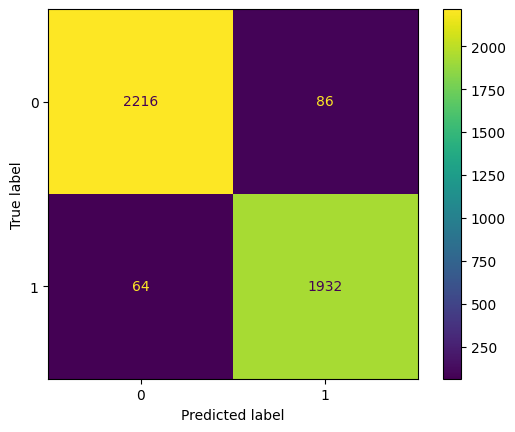

In [89]:
ConfusionMatrixDisplay.from_estimator(knn_clf, x_test_tr, y_test, values_format='d')

In [90]:
F1_KNN = f1_score(y_test, y_pred)
F1_KNN

0.9626307922272048

In [91]:
epochs_count = 50

# MLP

##  Defining Early Stopping, Learning Rate Sceduler, Class_weights callbacks


In [92]:
""" Additional parameter for reduce_lr"""
""" cooldown: Integer. Number of epochs to wait before resuming normal operation
after the learning rate has been reduced. """

# Calculate class weights using balanced weighting
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
# Convert class weights array to a dictionary with class indices as keys
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}


In [93]:
print (x_train_tr.shape[1])

31


In [94]:
input_shape = x_train_tr.shape[1]

# Simple model
model_1 = Sequential([
    Input(shape=(input_shape,)),
    Dense(8, activation='sigmoid'),
    Dense(4,  activation='relu'),
    Dense(2,  activation='relu'),
    Dense(1,  activation='sigmoid')
])

In [95]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 8)                   │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 305 (1.19 KB)

 Trainable params: 305 (1.19 KB)

 Non-trainable params: 0 (0.00 B)

In [96]:
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(0.1),
    loss='binary_crossentropy', metrics=['accuracy']
)

In [97]:
H = model_1.fit(x_train_tr, y_train,
                validation_data=(x_val_tr, y_val),
                epochs=epochs_count,
                verbose=False,
                batch_size=1024)

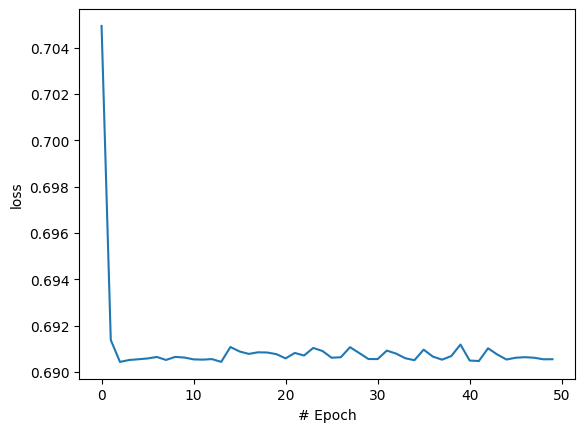

In [98]:
plt.xlabel("# Epoch")
plt.ylabel("loss")
plt.plot(H.history["loss"])

In [99]:
y_pred_prob = model_1.predict(x_val_tr)#.ravel()# CAlculate predicted probabilities
y_pred_labels = (y_pred_prob >= 0.5).astype(int)

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [100]:
cm = confusion_matrix(y_val, y_pred_labels)
cm

array([[2391,    0],
       [1906,    0]])

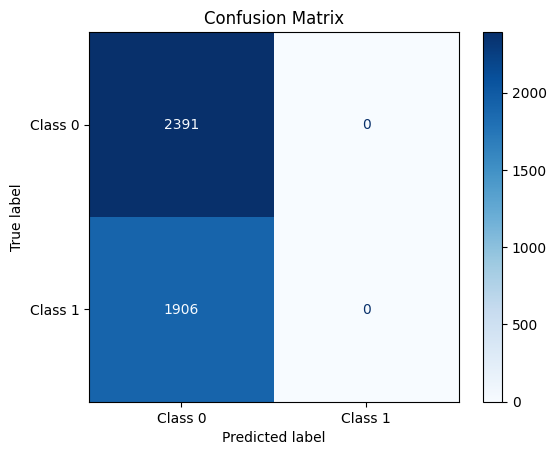

In [101]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [102]:
f1_score(y_val, y_pred_labels)

0.0

In [103]:
fpr, tpr, roc_thresholds = roc_curve(y_val, y_pred_prob) # Compute ROC Metrics
roc_auc = auc(fpr, tpr)
precision, recall, pr_thresholds = precision_recall_curve(y_val, y_pred_prob)

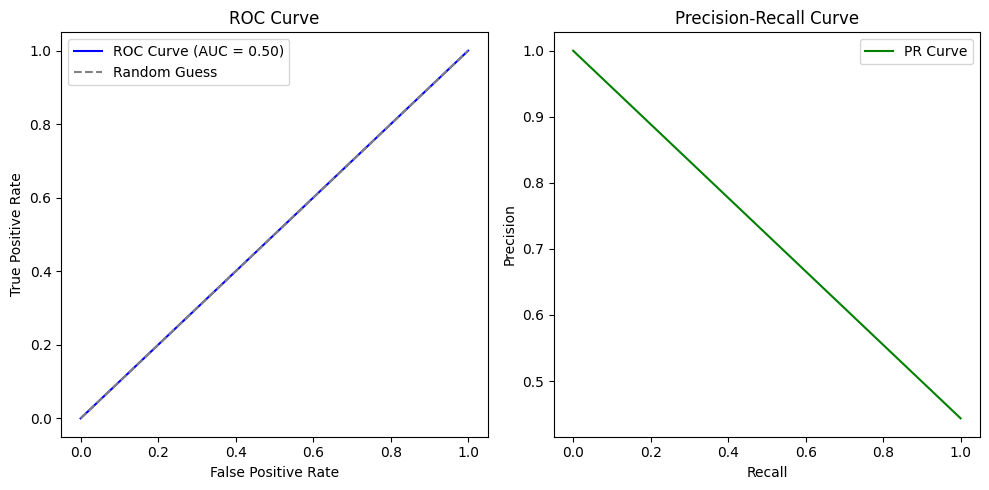

In [104]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [105]:
y_pred = model_1.predict(x_test_tr)

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [106]:
y_pred_labels = (y_pred > 0.5).astype(int)
y_pred_labels

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [107]:
DL1_F1 = f1_score(y_test, y_pred_labels)
DL1_F1

0.0

In [108]:
model_2 = Sequential([
    Input(shape=(input_shape,)),
    Dense(128, activation='sigmoid'),
    Dense(64,  activation='relu'),
    Dense(32,  activation='relu'),
    Dense(16,  activation='relu'),
    Dense(8,   activation='relu'),
    Dense(4,   activation='relu'),
    Dense(2,   activation='relu'),
    Dense(1,   activation='sigmoid')
])

In [109]:
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 128)                 │           4,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 2)                   │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,145 (59.16 KB)

 Trainable params: 15,145 (59.16 KB)

 Non-trainable params: 0 (0.00 B)

In [110]:
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(0.1),
    loss='binary_crossentropy', metrics=['accuracy']
)

In [111]:
H2 = model_2.fit(x_train_tr, y_train,
                validation_data=(x_val_tr, y_val),
                epochs=epochs_count,
                verbose=False,
                batch_size=1024)

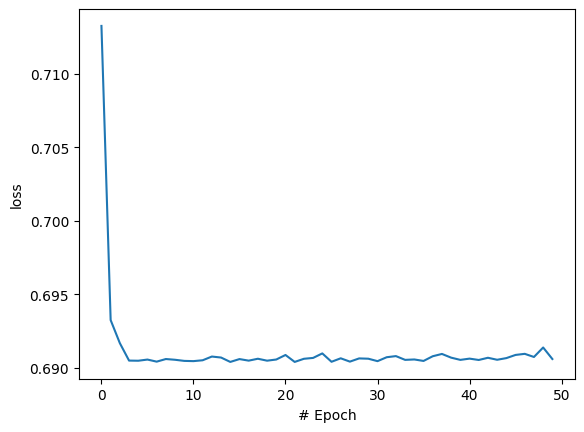

In [112]:
plt.xlabel("# Epoch")
plt.ylabel("loss")
plt.plot(H2.history["loss"])

In [113]:
y_pred_prob = model_2.predict(x_val_tr)#.ravel()# CAlculate predicted probabilities
y_pred_labels = (y_pred_prob >= 0.5).astype(int)

135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [114]:
cm = confusion_matrix(y_val, y_pred_labels)
cm

array([[2391,    0],
       [1906,    0]])

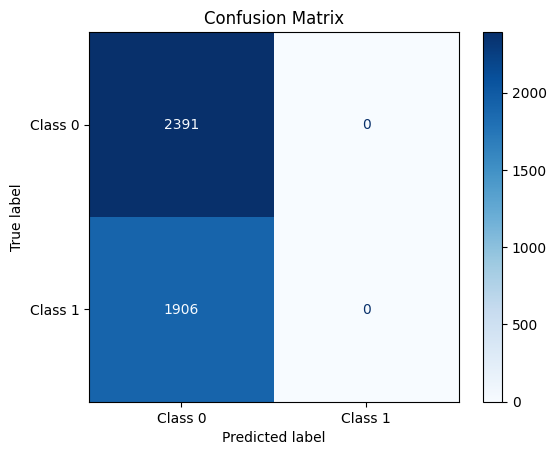

In [115]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [116]:
f1_score(y_val, y_pred_labels)

0.0

In [117]:
fpr, tpr, roc_thresholds = roc_curve(y_val, y_pred_prob) # Compute ROC Metrics
roc_auc = auc(fpr, tpr)
precision, recall, pr_thresholds = precision_recall_curve(y_val, y_pred_prob)

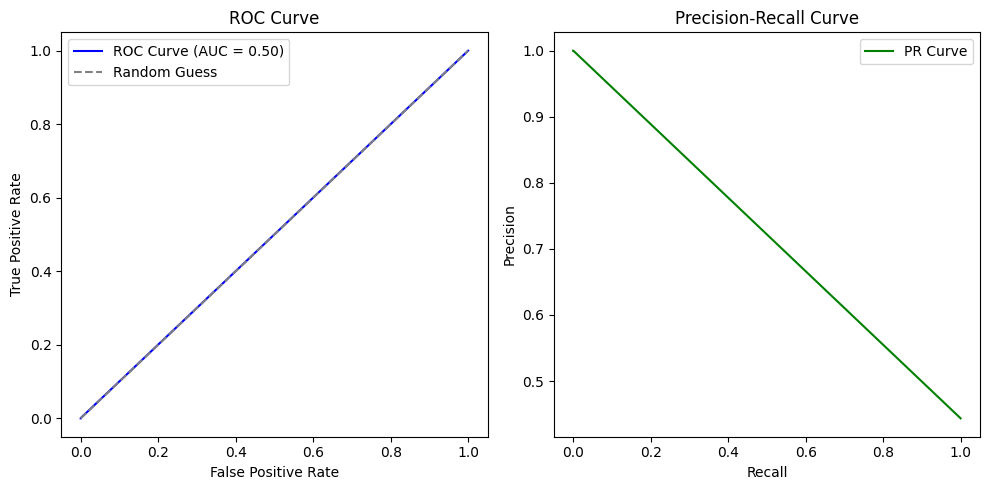

In [118]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [119]:
y_pred = model_2.predict(x_test_tr)

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [120]:
y_pred_labels = (y_pred > 0.5).astype(int)
y_pred_labels

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [121]:
DL2_F1 = f1_score(y_test, y_pred_labels)
DL2_F1

0.0

# CNN

In [122]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(x_train_tr.shape[1], 1)),  # Input layer
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])

In [123]:
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[F1ScoreMetric()]) # 'f1_score'

In [124]:
H3 = cnn_model.fit(x_train_tr, y_train,
                validation_data=(x_val_tr, y_val),
                epochs=epochs_count,
                verbose=False,
                batch_size=32)#1024

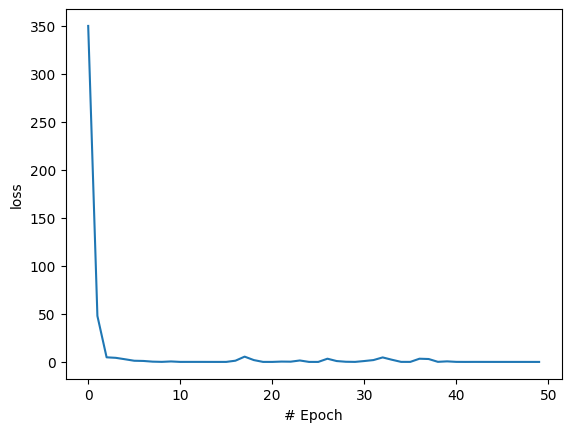

In [125]:
plt.xlabel("# Epoch")
plt.ylabel("loss")
plt.plot(H3.history["loss"])

In [126]:
y_pred_prob = cnn_model.predict(x_val_tr)#.ravel()# CAlculate predicted probabilities
y_pred_labels = (y_pred_prob >= 0.5).astype(int)

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [127]:
cm = confusion_matrix(y_val, y_pred_labels)
cm

array([[2361,   30],
       [ 111, 1795]])

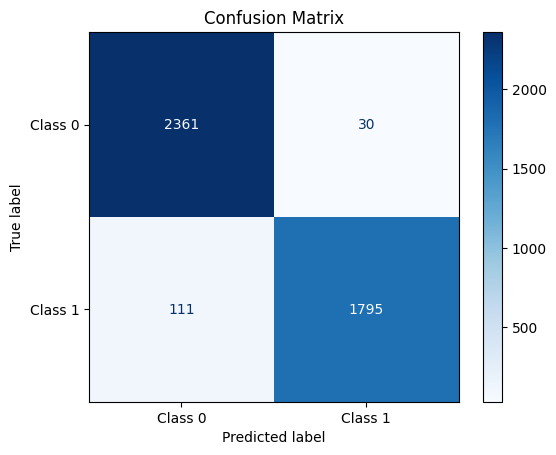

In [128]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [129]:
f1_score(y_val, y_pred_labels)

0.962208523184133

In [130]:
fpr, tpr, roc_thresholds = roc_curve(y_val, y_pred_prob) # Compute ROC Metrics
roc_auc = auc(fpr, tpr)
precision, recall, pr_thresholds = precision_recall_curve(y_val, y_pred_prob)

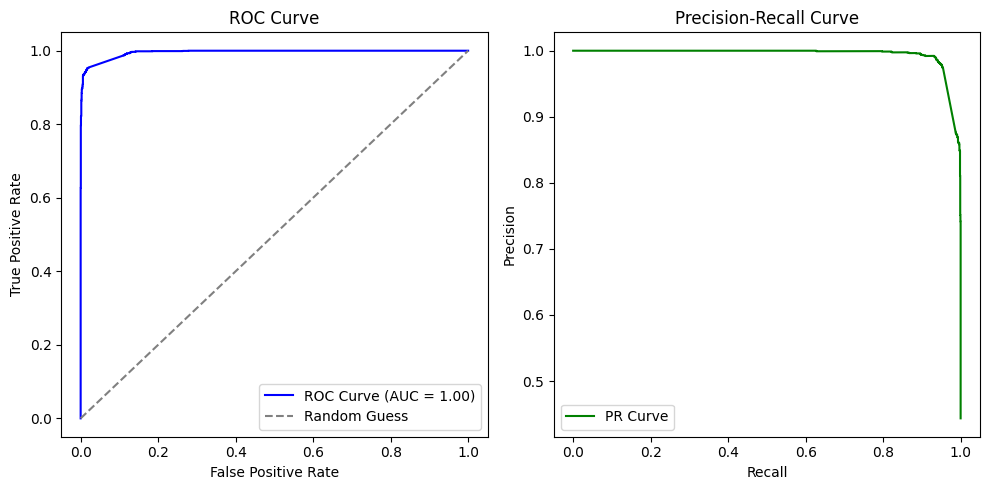

In [131]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [132]:
# Getting Predictions
y_pred = cnn_model.predict(x_test_tr)
y_pred_labels = (y_pred >= 0.5).astype(int)

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [133]:
CNN_F1 = f1_score(y_test, y_pred_labels)
CNN_F1

0.9596297248650039

# RNN

In [134]:
rnn_model = Sequential()

# Input layer and first LSTM layer
rnn_model.add(LSTM(units=50, activation='tanh', return_sequences=True, input_shape=(x_train_tr.shape[1], 1)))
rnn_model.add(Dropout(0.2))  # Prevent overfitting

# Second LSTM layer
rnn_model.add(LSTM(units=50, activation='tanh', return_sequences=False))
rnn_model.add(Dropout(0.2))

# Fully connected layer
rnn_model.add(Dense(units=25, activation='relu'))
rnn_model.add(Dropout(0.2))

# Output layer
rnn_model.add(Dense(units=1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [135]:
rnn_model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=[F1ScoreMetric()])

In [136]:
history = rnn_model.fit( x_train_tr, y_train,
                validation_data=(x_val_tr, y_val),
                epochs=epochs_count,
                verbose=False,
                batch_size=32)#1024   fit(x_train_tr, y_train, epochs=20, batch_size=32, validation_split=0.2,verbose=False)

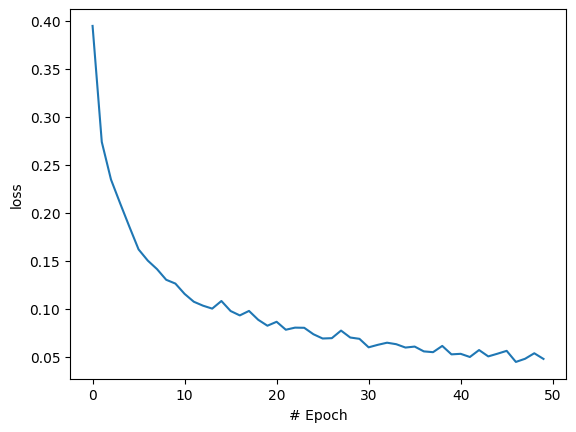

In [137]:
plt.xlabel("# Epoch")
plt.ylabel("loss")
plt.plot(history.history["loss"])

In [138]:
y_pred_prob = rnn_model.predict(x_val_tr)#.ravel()# CAlculate predicted probabilities
y_pred_labels = (y_pred_prob >= 0.5).astype(int)


135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


In [139]:
cm = confusion_matrix(y_val, y_pred_labels)
cm

array([[2342,   49],
       [  36, 1870]])

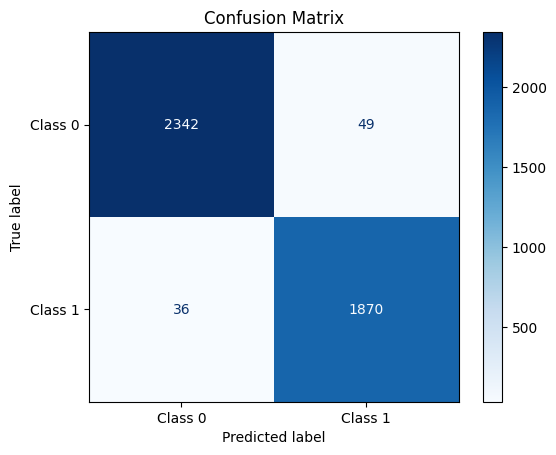

In [140]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [141]:
f1_score(y_val, y_pred_labels)

0.9777777777777777

In [142]:
fpr, tpr, roc_thresholds = roc_curve(y_val, y_pred_prob) # Compute ROC Metrics
roc_auc = auc(fpr, tpr)
precision, recall, pr_thresholds = precision_recall_curve(y_val, y_pred_prob)

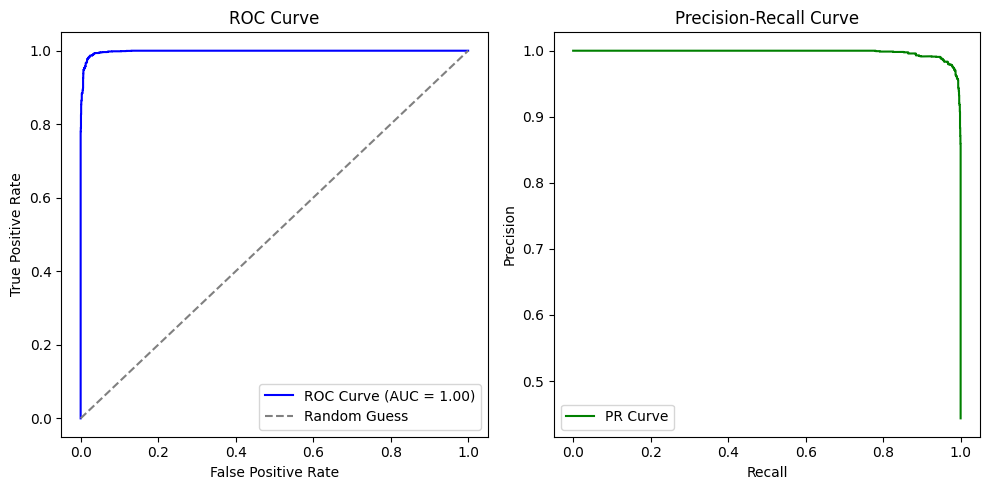

In [143]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [144]:
# Get Predictions
y_pred = rnn_model.predict(x_test_tr)
y_pred_binary = (y_pred >= 0.5).astype(int)

135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [145]:
f1 = f1_score(y_test, y_pred_binary)
print(f"Test F1-Score: {f1:.2f}")

Test F1-Score: 0.98


# TRANFORMERS

In [146]:
# 3. Compile the Model
num_features = x_train_tr.shape[1]
tf_model = build_transformer_model(input_dim=num_features, num_features=num_features)

tf_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[F1ScoreMetric()])#metrics=['accuracy', tf.keras.metrics.AUC()]

# Summary
tf_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 31)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 31, 1)          │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 31, 64)         │            128 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_encoding       │ (None, 31, 64)         │              0 │ dense_16[0][0]         │
│ (PositionalEncoding)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 31, 64)         │         66,368 │ positional_encoding[0… │
│ (MultiHeadAttention)      │                        │                │ positional_encoding[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 31, 64)         │              0 │ positional_encoding[0… │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 31, 64)         │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 31, 64)         │            128 │ layer_normalization[0… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 31, 64)         │         66,368 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 31, 64)         │              0 │ layer_normalization_1… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 31, 64)         │            128 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 31, 64)         │            128 │ layer_normalization_2… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 64)             │              0 │ layer_normalization_3… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 64)             │          4,160 │ global_average_poolin… │
├──────────────────────

 Total params: 137,601 (537.50 KB)

 Trainable params: 137,601 (537.50 KB)

 Non-trainable params: 0 (0.00 B)

In [147]:
checkpoint_path = 'best_transformer_model.keras'
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)
]

In [148]:
#  Train the Model
tf_history = tf_model.fit(
    x_train_tr,
    y_train,
    validation_data=(x_val_tr, y_val),
    epochs=epochs_count,
    batch_size=32,
    callbacks=callbacks,
    verbose=False
)

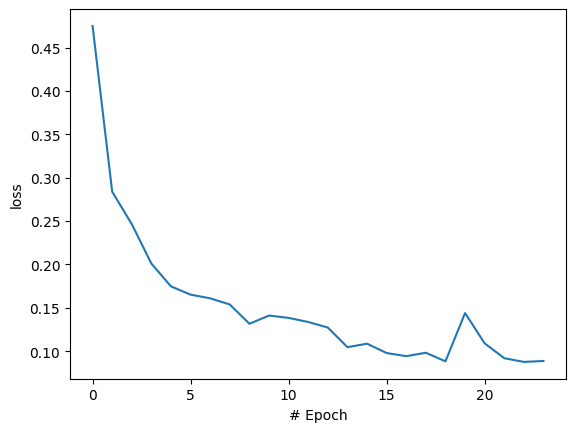

In [149]:
plt.xlabel("# Epoch")
plt.ylabel("loss")
plt.plot(tf_history.history["loss"])

In [150]:
y_pred_prob = tf_model.predict(x_val_tr)#.ravel()# CAlculate predicted probabilities
y_pred_labels = (y_pred_prob >= 0.5).astype(int)

135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


In [151]:
cm = confusion_matrix(y_val, y_pred_labels)
cm

array([[2326,   65],
       [  58, 1848]])

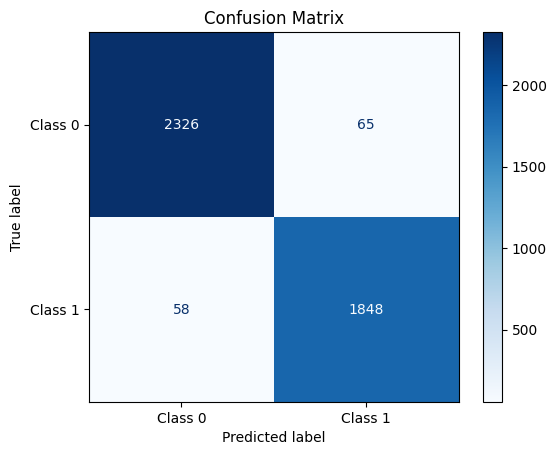

In [152]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [153]:
f1_score(y_val, y_pred_labels)

0.9677926158680282

In [154]:
fpr, tpr, roc_thresholds = roc_curve(y_val, y_pred_prob) # Compute ROC Metrics
roc_auc = auc(fpr, tpr)
precision, recall, pr_thresholds = precision_recall_curve(y_val, y_pred_prob)


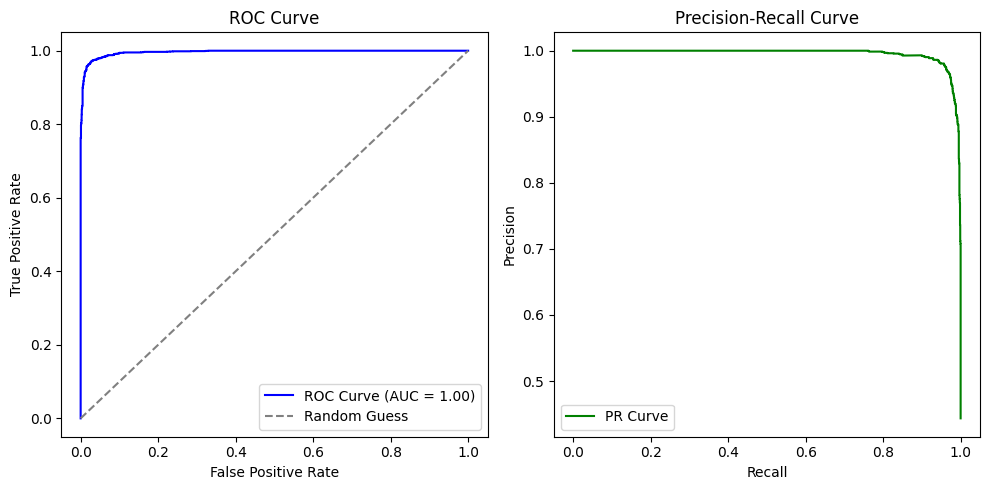

In [155]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [156]:
# Get Predictions
y_pred = tf_model.predict(x_test_tr)
y_pred_binary = (y_pred >= 0.5).astype(int)
#test_loss, test_accuracy, test_auc = tf_model.evaluate(x_test_tr, y_test, verbose=True)
#print(f"Test Loss: {test_loss:.4f}")
#print(f"Test Accuracy: {test_accuracy:.4f}")
#print(f"Test AUC: {test_auc:.4f}")
#y_pred_binary = (y_pred >= 0.5).astype(int)

135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


In [157]:
TF_F1 = f1_score(y_test, y_pred_binary)
TF_F1

0.970440881763527

# END

In [158]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 2407.69034409523 seconds ---
